GA - Genetic Algorithm ou Algoritmo Genético é uma metaheurística derivada da Computação Evolucionária tendo como um dos primeiros pesquisadores Melanie Mitchell em 1996 que se propõe resolver problemas de otimização e busca inspirado no processo de seleção natural fazendo uso de operadores como mutação, cruzamento e seleção.

Mitchell, M. Genetic algorithms: An overview. Complexity, Volume 1, Issue 1 Pages: 4-67. https://doi.org/10.1002/cplx.6130010108, 1995.

In [ ]:
#instala biblioteca Orange Canvas
!pip install Orange3

In [ ]:
#importa bibliotecas
import Orange
import random
import math
import matplotlib.pyplot as plt
from numpy.random import choice

In [ ]:
#define os hiperparâmetros
DIMENSOES = 2 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos (episódios) especificando quantas explorações podem ser realizadas
POPULACAO = 20 #tamanho da população correspondente ao número de formigas no formigueiro
E1 = -5 #extremo esquerdo eixo x
E2 = 5 #extremo direito eixo x
E3 = 0 #extremo inferior eixo y
E4 = 100 #extremo superior eixo y
LIMITES = [E1,E4] #(bound) determina os valores mínimos e máximos do espaço de busca
FCUSTO = 'distância' #(fitness) define a aptidão do indivíduo na possível solução do problema
TORNEIO = 0.4 # taxa do método de seleção torneio
ROLETA = 0.6 # taxa do método de seleção roleta
MUTACAO = 0.1 # taxa do operador de mutação
INDIVIDUOS = [] #(swarm) array da criação dos indivíduos da população

In [ ]:
#importa dados
from google.colab import files
files.upload()

In [ ]:
#instancia objeto de dados com base no caminho gerado na importação do arquivo
dados = Orange.data.Table("/content/processos.csv")

In [ ]:
#explora os metadados e dados da arquivo importado
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
dados.domain.attributes #explora os domínios dos atributos (campos da base de dados)
print("Registros:", len(dados)) #explora os dados (quantidade de registros da base de dados)
i = 0 #exibe os primeiros registros para análise dos dados importados
for d in dados[:20]:
  i += 1
  print(i, d)

In [ ]:
#cria arrays das dimensões do problema a ser otimizado
periodo = []
complexidade = [] #1-muito baixa complexidade;2-baixa complexidade;3-média complexidade;4-alta complexidade;e,5-muito alta complexidade
pagina = []
prazo = []
revisao = []
entrega = []
i = 0
for d in dados[:POPULACAO]:
  periodo.append(d[1])
  complexidade.append(d[2])
  pagina.append(d[3])
  prazo.append(d[4])
  revisao.append(d[5])
  entrega.append(d[6])
  print("id:",i,"período:",periodo[i],"complexidade:",complexidade[i],"página:",pagina[i],"prazo:",prazo[i],"revisões:",revisao[i],"entrega:",entrega[i])
  per = periodo[i]
  cpx = complexidade[i]
  pag = pagina[i]
  prz = prazo[i]
  rev = revisao[i]
  ent = entrega[i]
  i += 1

In [ ]:
#função custo ou objetivo ou aptidão ou otimização ou fitness - usada para buscar o melhor ponto dentro de um espaço de buscao (melhor global) sem ficar preso em um melhor local
def fcusto(problema, possivel_solucao, alfa=0, beta=0, gama=0, delta=0, epsilon=0, zeta=0):
  total = 0.0
  if problema == 'rosenbrock':
    for i in range(DIMENSOES-1):
      total += 100*(possivel_solucao[i+1] - possivel_solucao[i]**2)**2 + (1-possivel_solucao[i])**2
  elif problema == 'esfera':
    for i in range(DIMENSOES):
      total += possivel_solucao[i]**2
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(sum([coord ** 2 for coord in possivel_solucao]))
  elif problema == 'caminho':
    denominador = sum([(caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta for caminho in possivel_solucao])
    distribuicao_probabilidades = None
    if denominador == 0:
      distribuicao_probabilidades = [1 / len(possivel_solucao)  for _ in possivel_solucao]
    else:
      distribuicao_probabilidades = [((caminho.feromonio)**alfa * (1 / caminho.comprimento)**beta) / denominador for caminho in possivel_solucao]
    total = choice(possivel_solucao, 1, p=distribuicao_probabilidades)[0]
  elif problema == "distância":
    total = 0
    for i in range(POPULACAO):
      if i < POPULACAO - 1:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[i+1]])
      else:
        total += pontos[possivel_solucao[i]].distancia(pontos[possivel_solucao[0]])
    total = 1/total
  else:
    print('Problema não encontrado!')
  return total

In [ ]:
#indivíduo - unidade base da otimização, posicionada numa determinada posição no espaço de busca do problema, representando uma solução em potencial para o problema
class Individuo:
  def __init__(self, x, y):
    self.posicao_x = x
    self.posicao_y = y
  def distancia(self, individuo_outro):
    return math.sqrt((self.posicao_x - individuo_outro.posicao_x)**2 + (self.posicao_y - individuo_outro.posicao_y)**2)

In [ ]:
#mutação - operação que modifica aleatoriamente alguma característica do indivíduo criando novos valores de características em uma pequena quantidade da população
#introduzindo diversidade genética na população e assegurando a probabilidade de se chegar a qualquer ponto do espaço de busca
def mutacao(individuo):
  if random.random() < MUTACAO:
    individuo_mutado = []
    aux_1 = random.randint(0, POPULACAO-1)
    aux_2 = random.randint(0, POPULACAO-1)
    while(aux_1 == aux_2):
      aux_2 = random.randint(0, POPULACAO-1)
    if aux_2 < aux_1:
      aux_3 = aux_1
      aux_1 = aux_2
      aux_2 = aux_3
    for i in range(aux_1):
      individuo_mutado.append(individuo[i])
    for i in range(aux_2-1, aux_1-1, -1):
      individuo_mutado.append(individuo[i])
    for i in range(aux_2, len(individuo)):
      individuo_mutado.append(individuo[i])
    return individuo_mutado
  return individuo

In [ ]:
#crossover - operação de cruzamento onde novos indivíduos são criados com base na misturando características de dois indivíduos (pais) com parte da caracetrística trocada
#por trecho equivalente do outro indivíduo resultando em um novo indivíduo que potencialmente combina as melhores características dos indivíduos pais
def crossover(individuos, pais):
  aux_1 = random.randint(0, POPULACAO-1)
  aux_2 = random.randint(0, POPULACAO-1)
  if aux_2 < aux_1:
    aux_3 = aux_1
    aux_1 = aux_2
    aux_2 = aux_3
  list_pai = individuos[pais[0]][aux_1:aux_2]
  filho = []
  i = 0
  while len(filho) < aux_1:
    if individuos[pais[1]][i] not in list_pai:
      filho.append(individuos[pais[1]][i])
    i+=1
  filho = filho + list_pai
  i = 0
  while len(filho) < POPULACAO:
    if individuos[pais[1]][i] not in filho:
      filho.append(individuos[pais[1]][i])
    i+=1
  return filho

In [ ]:
#selecao - operação de seleção de um indivíduo de uma população para aplicação dos operadores genéticos através de um valor aptidão podendo ser através de uma dos métodos "torneio" ou "roleta"
def selecao_base(fitness):
  pais = []
  for i in range(POPULACAO):
    pais.append(torneio(fitness))
  return pais

In [ ]:
#torneio - um número n de indivíduos da população é escolhido aleatoriamente para formar uma sub-população temporária
#deste grupo o indivíduo selecionado dependerá de uma probabilidade k definida previamente
def torneio(fitness):
  pais = []
  for k in range(0, 2):
    individuos_torneio = []
    for i in range(POPULACAO):
      aux = random.random()
      if aux < TORNEIO:
        individuos_torneio.append(i)
    while len(individuos_torneio) < 2:
      individuos_torneio.append(random.randint(0, POPULACAO-1))
    best = fitness[individuos_torneio[0]]
    best_ind = individuos_torneio[0]
    for i in range(len(individuos_torneio)):
      if fitness[individuos_torneio[i]] > best:
        best = fitness[individuos_torneio[i]]
        best_ind = individuos_torneio[i]
    pais.append(best_ind)
  return pais

In [ ]:
#roleta - cada indivíduo da população é representado proporcionalmente ao seu índice de aptidão
#assim indivíduos com alta aptidão possuem uma porção maior na roleta
def roleta(fitness):
  pais = []
  for k in range(0, 2):
    individuos_roleta = []
    for i in range(POPULACAO):
      aux = random.random()
      if aux < ROLETA:
        individuos_roleta.append(i)
    while len(individuos_roleta) < 2:
      individuos_roleta.append(random.randint(0, POPULACAO-1))
    best = fitness[individuos_roleta[0]]
    best_ind = individuos_roleta[0]
    for i in range(len(individuos_roleta)):
      if fitness[individuos_roleta[i]] > best:
        best = fitness[individuos_roleta[i]]
        best_ind = individuos_roleta[i]
    pais.append(best_ind)
  return pais

In [ ]:
#calcula posições (soluções)
def calcula_solucao():
  lista_individuos = list(range(POPULACAO))
  lista_aleatoria = []
  for i in range(POPULACAO):
    individuo = random.choice(lista_individuos)
    lista_aleatoria.append(individuo)
    lista_individuos.remove(individuo)
  return lista_aleatoria

In [ ]:
#plota posições no gráfico
def exibe_grafico(titulo, lista_pontos, solucao):
  x = []
  y = []
  for i in range(POPULACAO):
    x.append(lista_pontos[solucao[i]].posicao_x)
    y.append(lista_pontos[solucao[i]].posicao_y)
    plt.plot(lista_pontos[solucao[i]].posicao_x, lista_pontos[solucao[i]].posicao_y, 'ro')
  x.append(lista_pontos[solucao[0]].posicao_x)
  y.append(lista_pontos[solucao[0]].posicao_y)
  plt.axis([E1,E2,E3,E4])
  plt.plot(0,0, marker='*', markersize=10, linewidth=0.8, color='b')
  plt.plot(x,y, color='c')
  plt.title(titulo)
  plt.show()

In [ ]:
#inicializa população (indivíduos)
for i in range(POPULACAO):
  cpx = complexidade[i]
  pag = pagina[i]
  posicao = [cpx,pag]
  INDIVIDUOS.append(posicao)
  print("indivíduo:",i,"complexidade:",INDIVIDUOS[-1][0],"página:",INDIVIDUOS[-1][1])

indivíduo: 0 complexidade: 2 página: 37
indivíduo: 1 complexidade: 2 página: 2
indivíduo: 2 complexidade: 4 página: 82
indivíduo: 3 complexidade: 2 página: 17
indivíduo: 4 complexidade: 3 página: 11
indivíduo: 5 complexidade: 2 página: 48
indivíduo: 6 complexidade: 1 página: 18
indivíduo: 7 complexidade: 1 página: 3
indivíduo: 8 complexidade: 2 página: 4
indivíduo: 9 complexidade: 1 página: 7
indivíduo: 10 complexidade: 2 página: 27
indivíduo: 11 complexidade: 2 página: 48
indivíduo: 12 complexidade: 3 página: 89
indivíduo: 13 complexidade: 4 página: 11
indivíduo: 14 complexidade: 1 página: 6
indivíduo: 15 complexidade: 3 página: 64
indivíduo: 16 complexidade: 3 página: 18
indivíduo: 17 complexidade: 3 página: 5
indivíduo: 18 complexidade: 4 página: 73
indivíduo: 19 complexidade: 2 página: 7


In [ ]:
#posiciona os indivíduos no espaço de busca
pontos = []
for i in range(POPULACAO):
  pontos.append(Individuo(INDIVIDUOS[i][0], INDIVIDUOS[i][1]))
individuos = []
fitness = []
fitness_tempo = []
for i in range(POPULACAO):
  individuos.append(calcula_solucao())
  fitness.append(fcusto(FCUSTO,individuos[-1]))
exibe_grafico('Posicição Inicial',pontos,individuos[0])

Iteração: 1


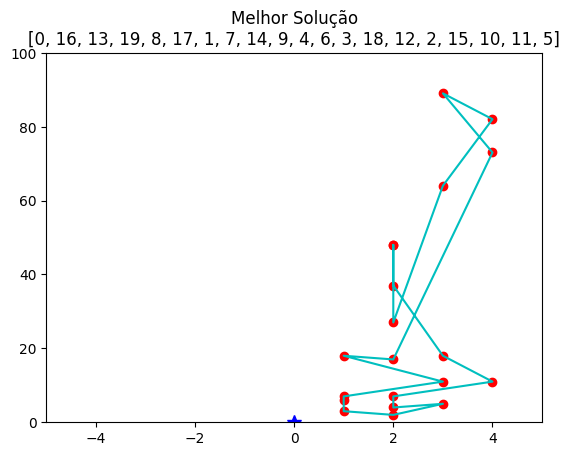

Iteração: 2


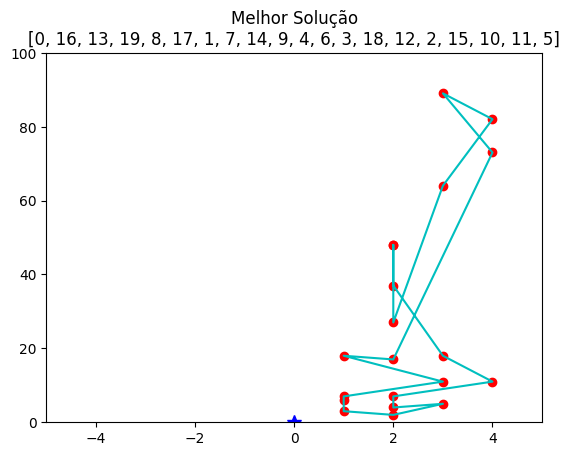

Iteração: 3


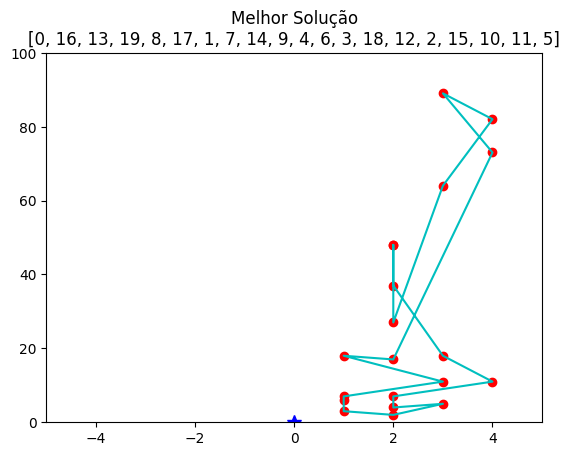

Iteração: 4


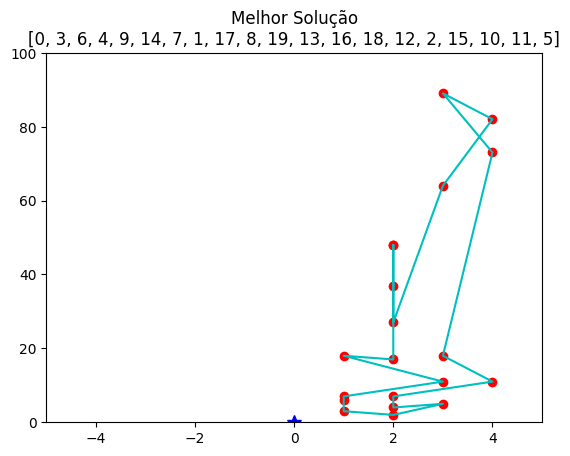

Iteração: 5


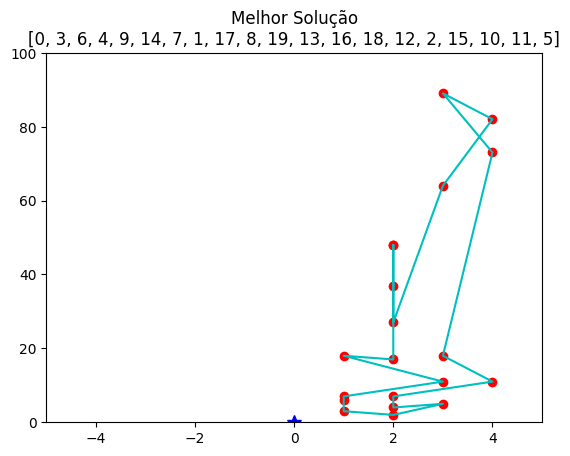

Iteração: 6


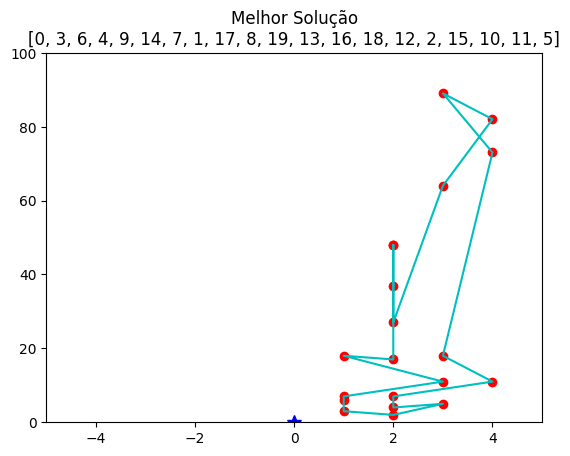

Iteração: 7


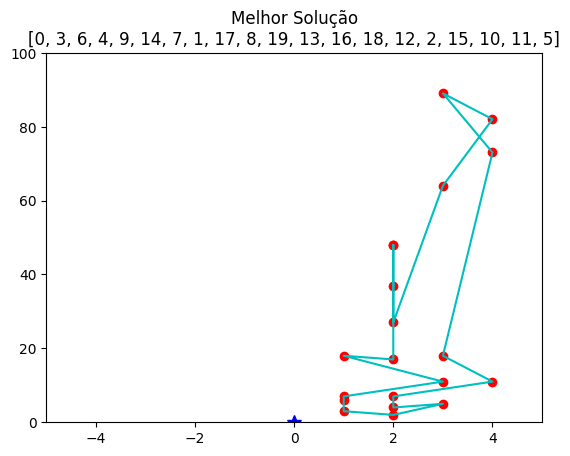

Iteração: 8


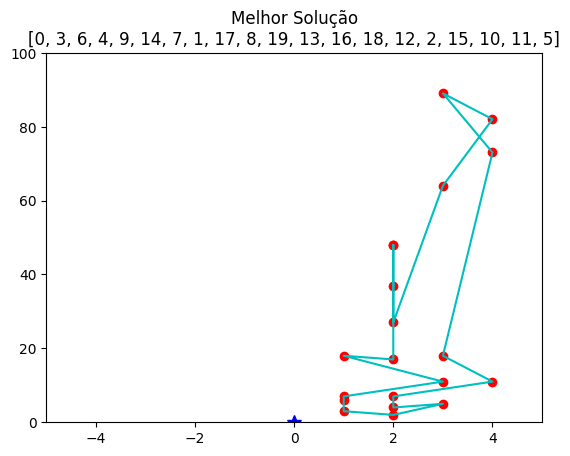

Iteração: 9


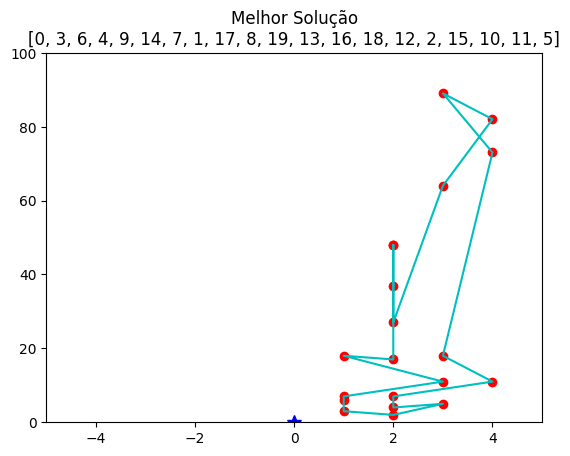

Iteração: 10


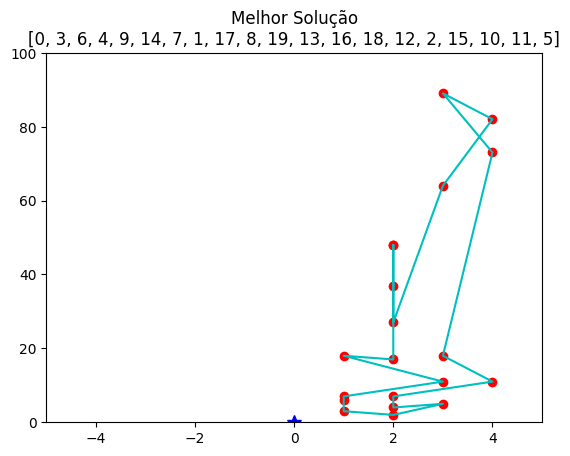

Iteração: 11


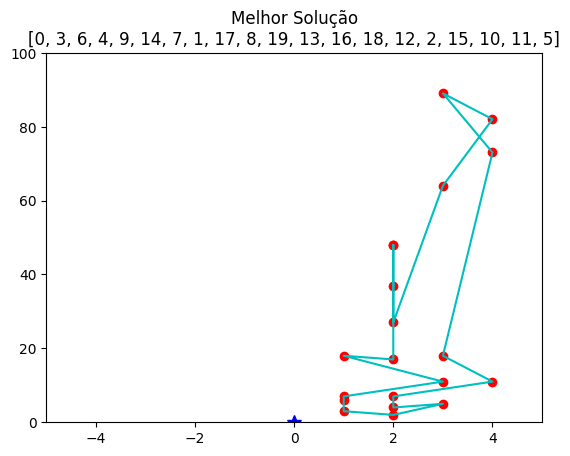

Iteração: 12


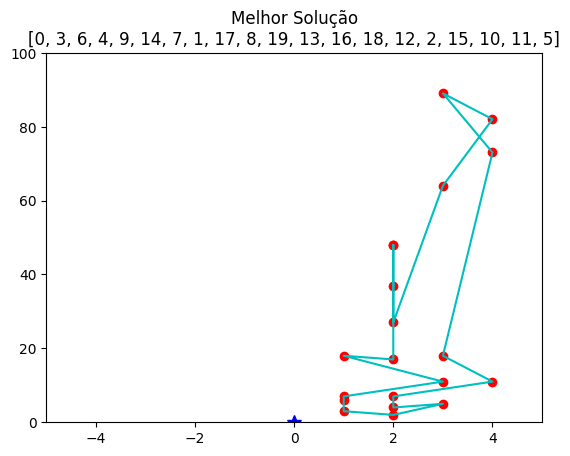

Iteração: 13


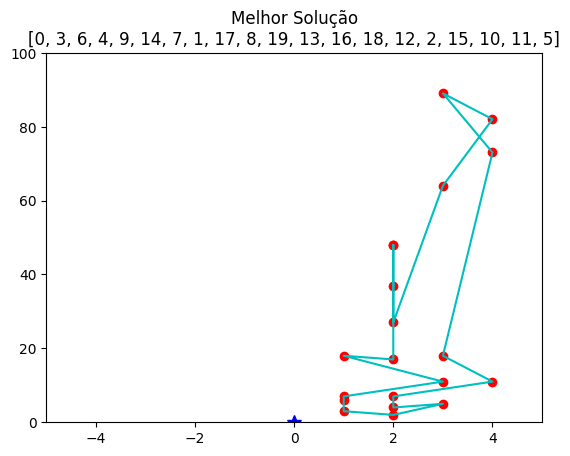

Iteração: 14


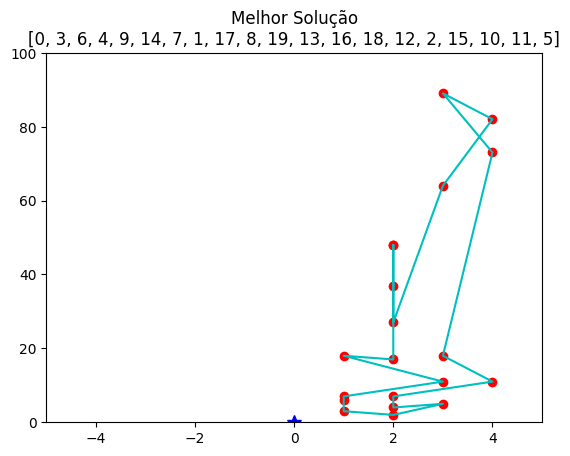

Iteração: 15


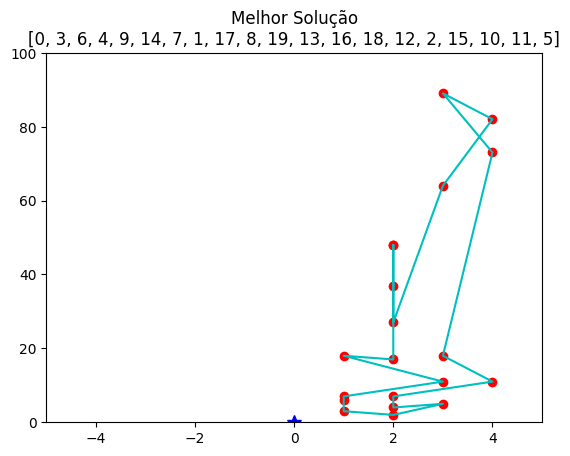

Iteração: 16


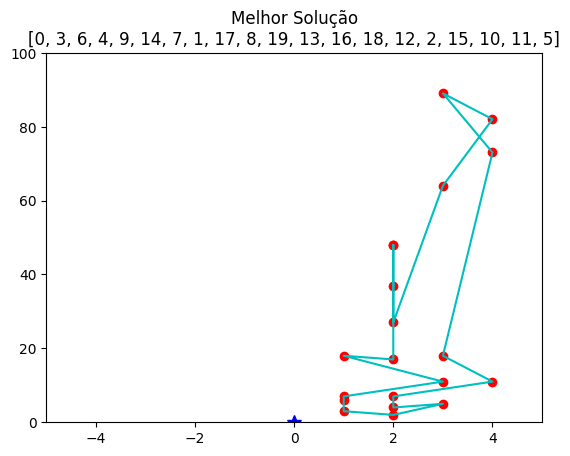

Iteração: 17


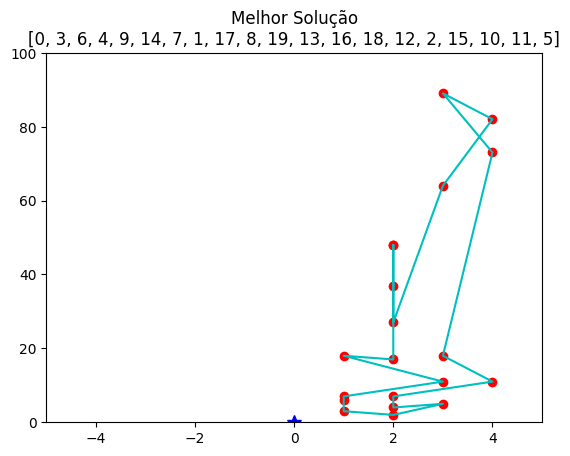

Iteração: 18


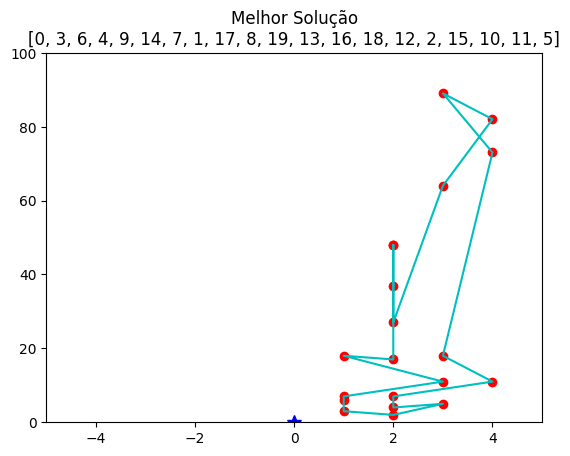

Iteração: 19


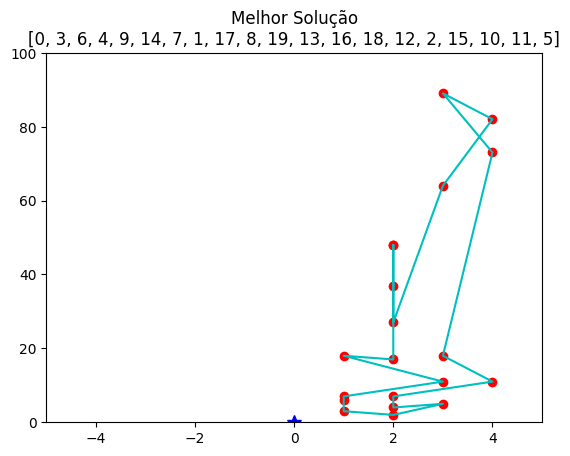

Iteração: 20


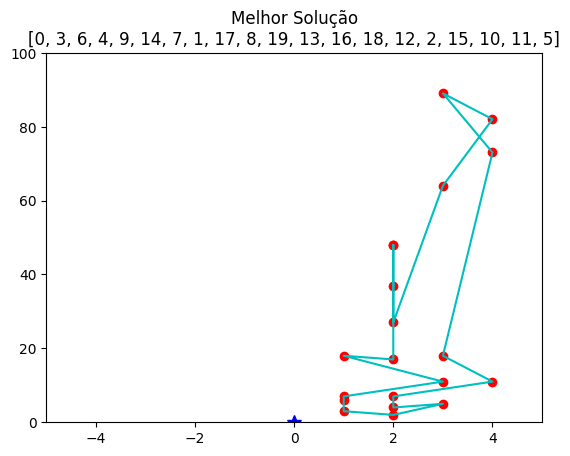

Iteração: 21


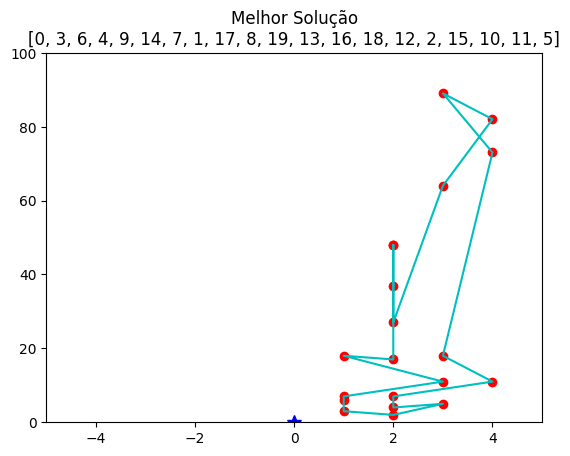

Iteração: 22


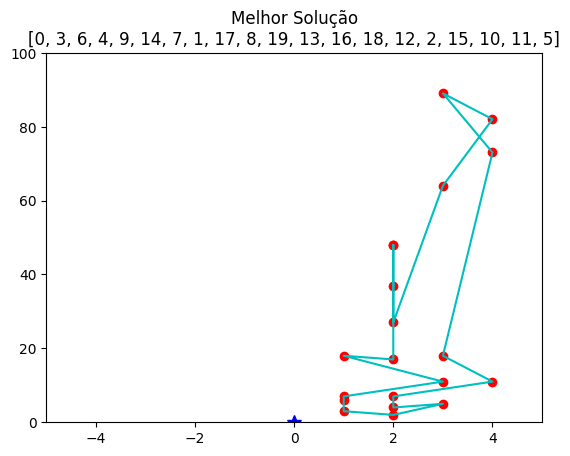

Iteração: 23


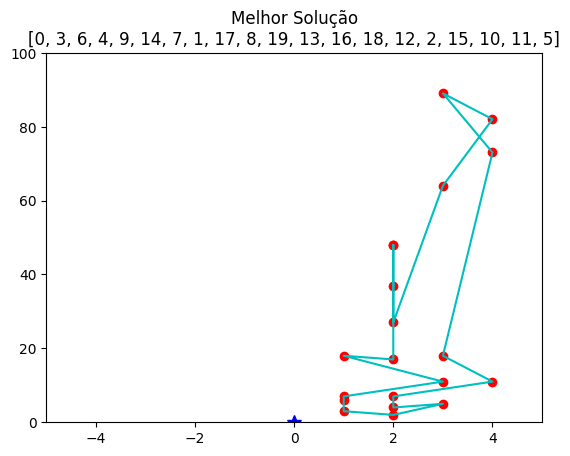

Iteração: 24


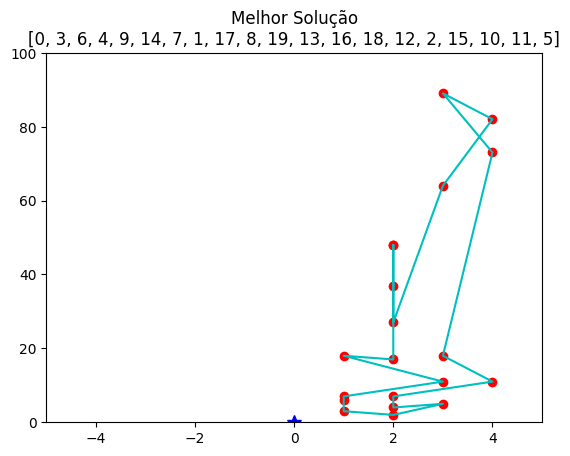

Iteração: 25


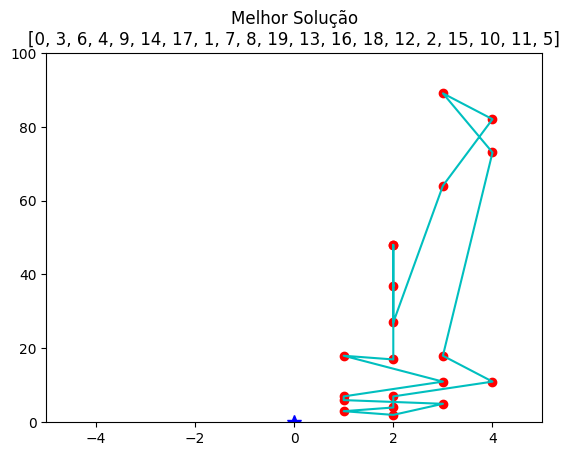

Iteração: 26


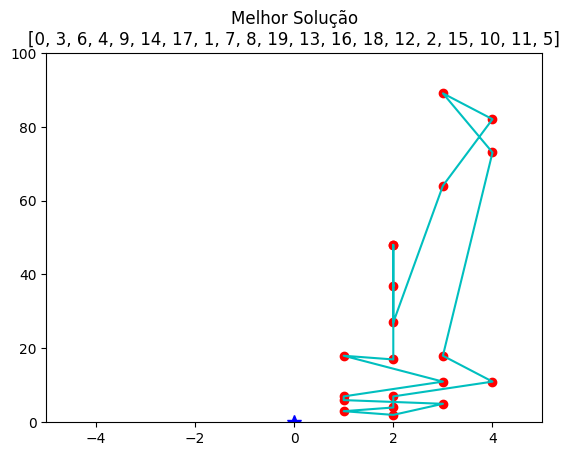

Iteração: 27


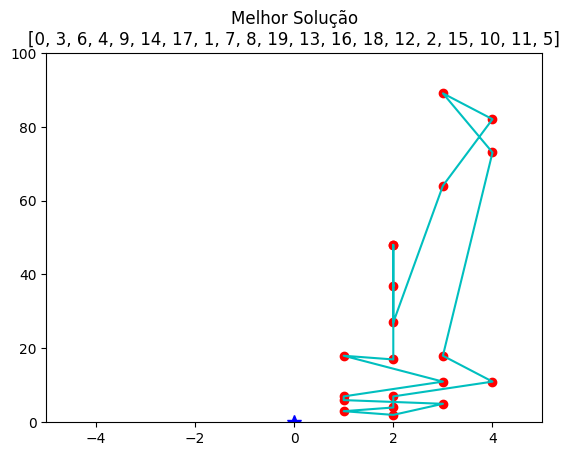

Iteração: 28


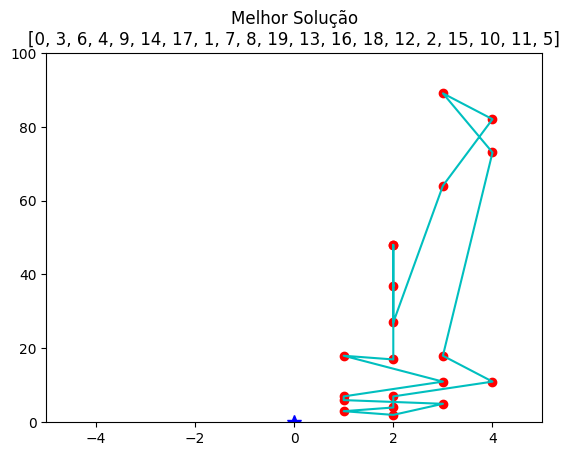

Iteração: 29


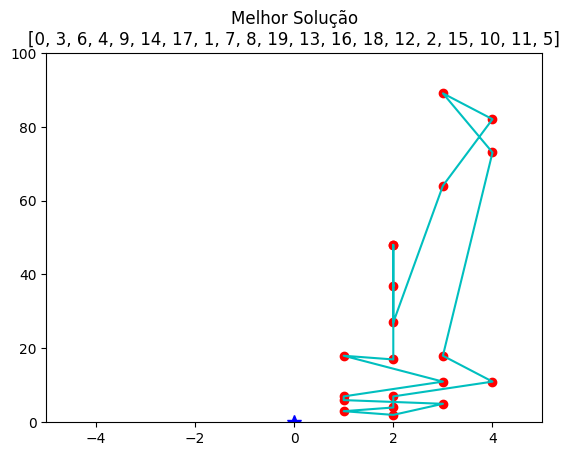

Iteração: 30


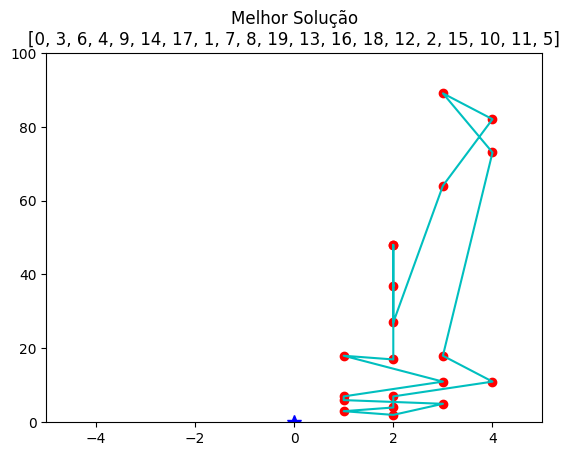

Iteração: 31


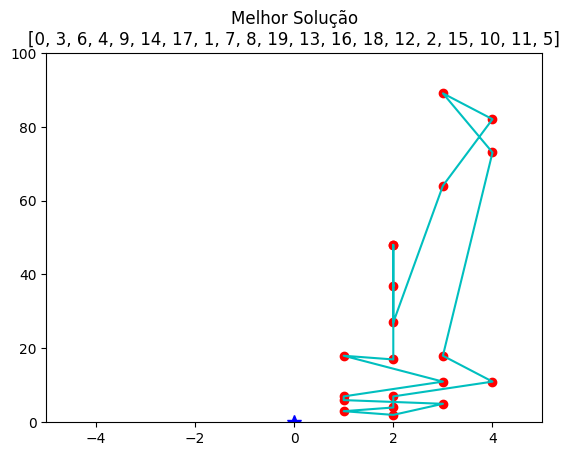

Iteração: 32


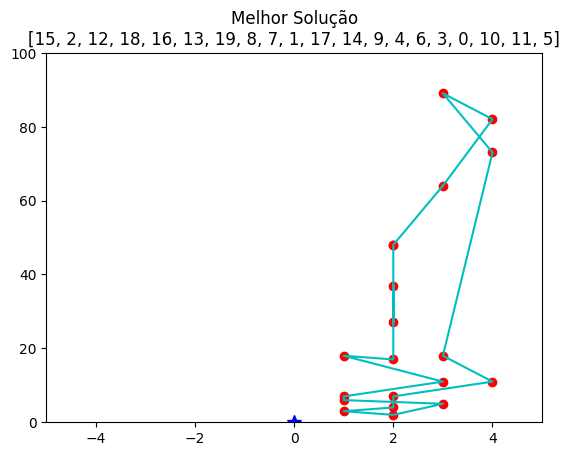

Iteração: 33


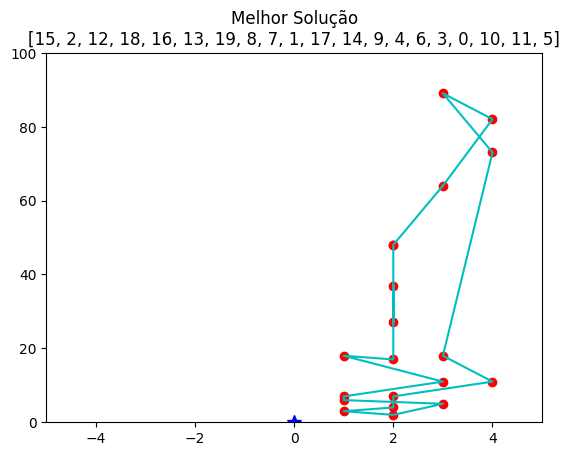

Iteração: 34


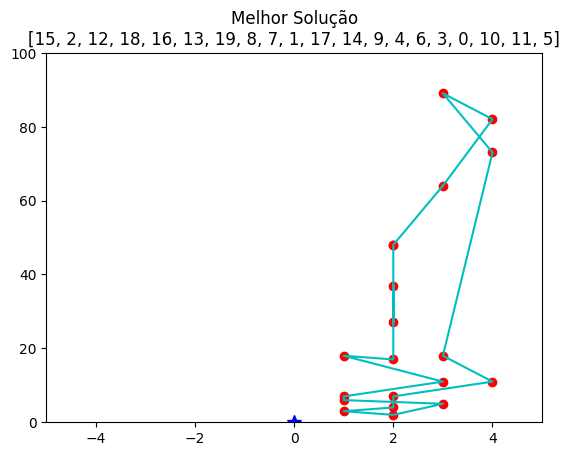

Iteração: 35


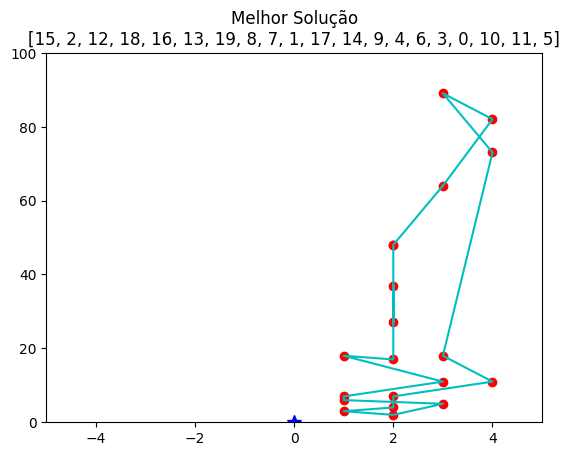

Iteração: 36


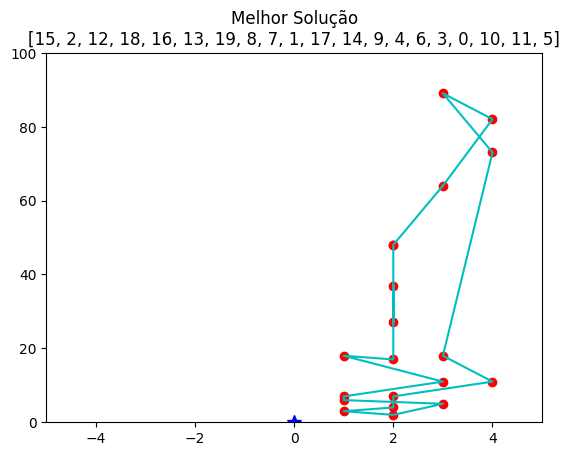

Iteração: 37


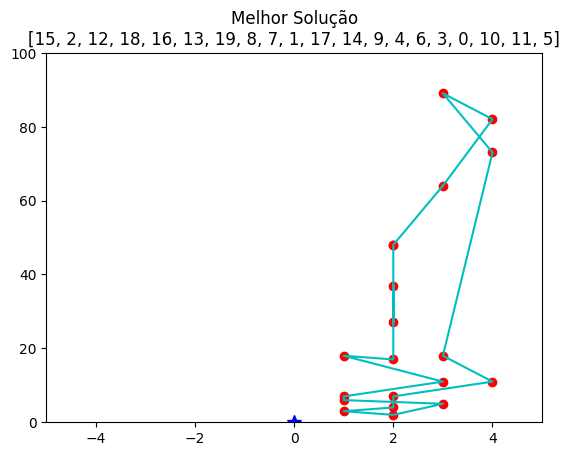

Iteração: 38


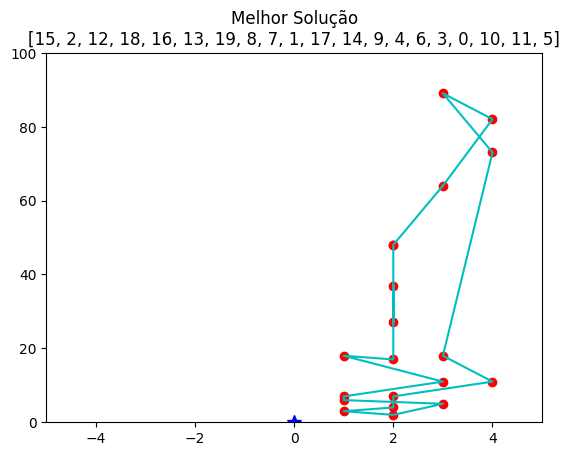

Iteração: 39


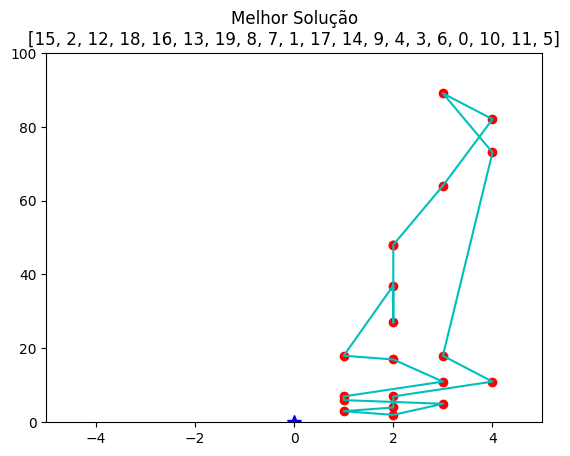

Iteração: 40


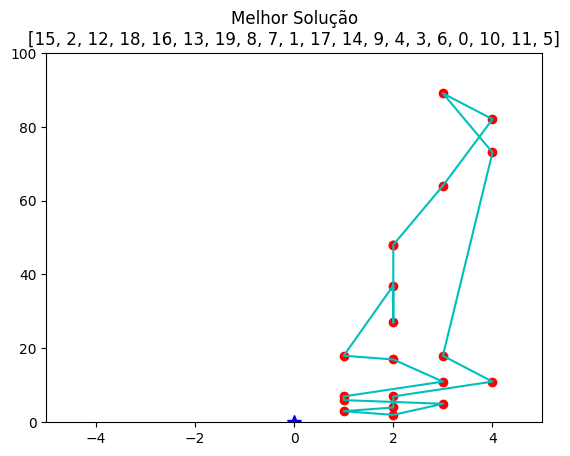

Iteração: 41


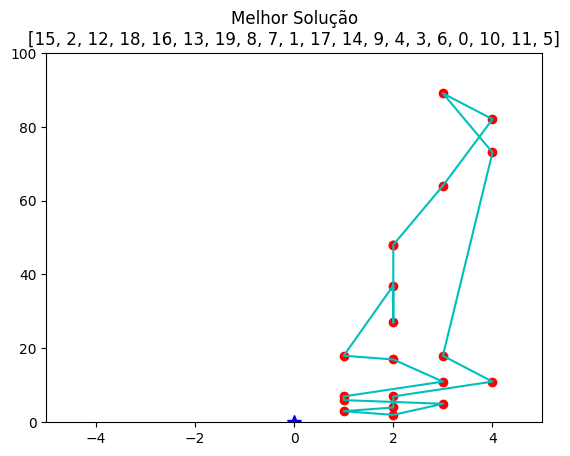

Iteração: 42


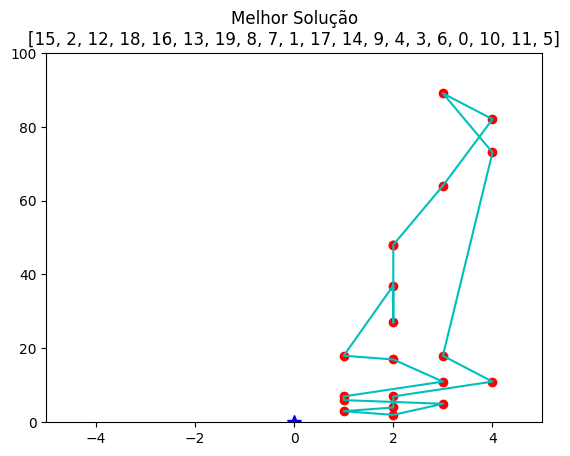

Iteração: 43


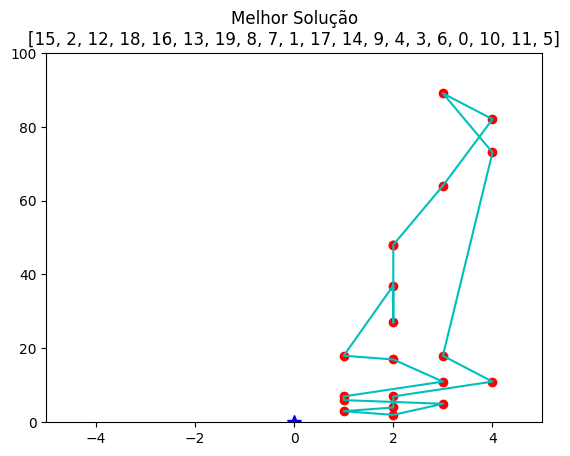

Iteração: 44


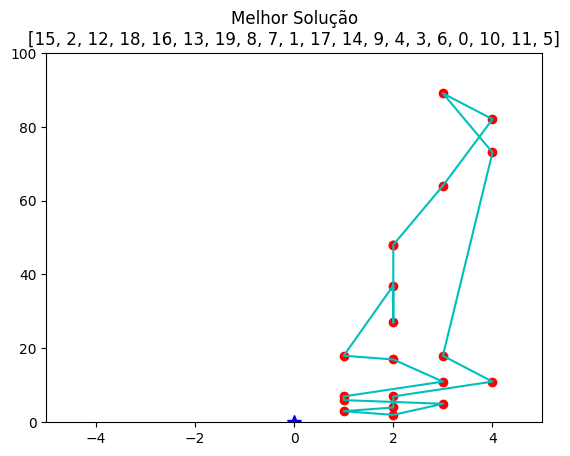

Iteração: 45


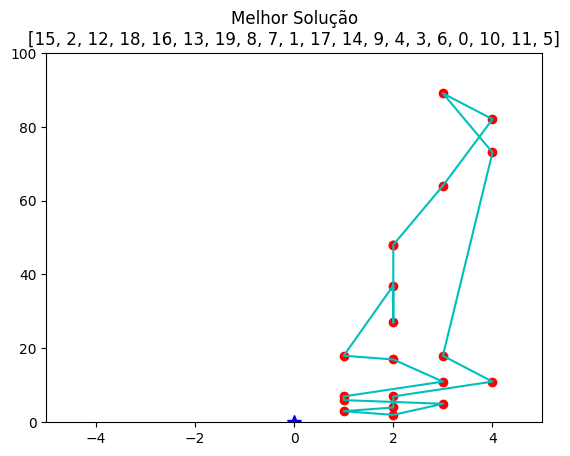

Iteração: 46


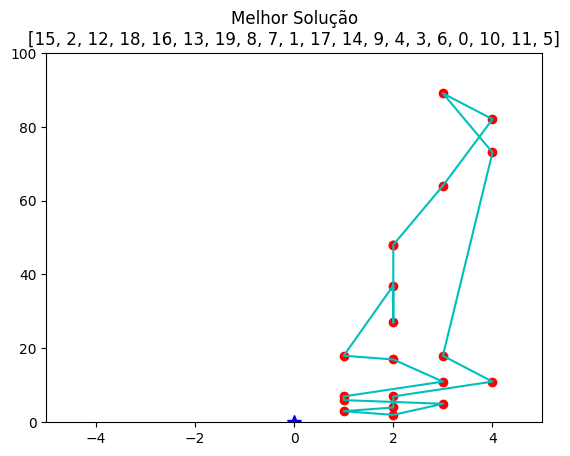

Iteração: 47


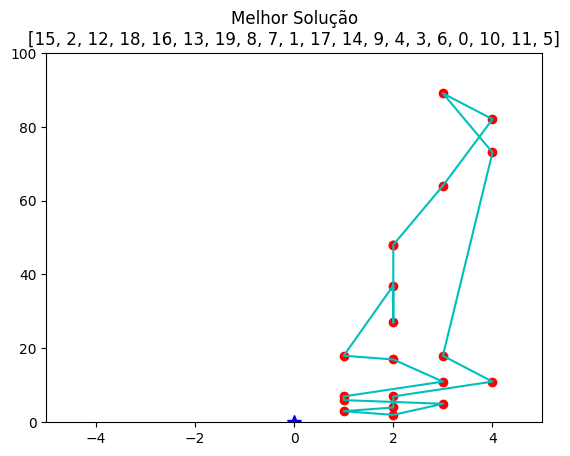

Iteração: 48


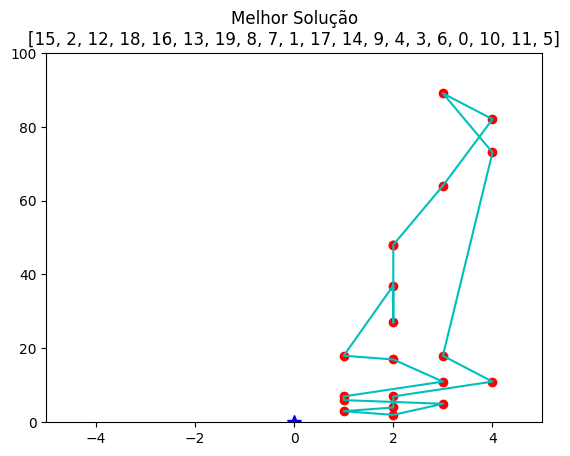

Iteração: 49


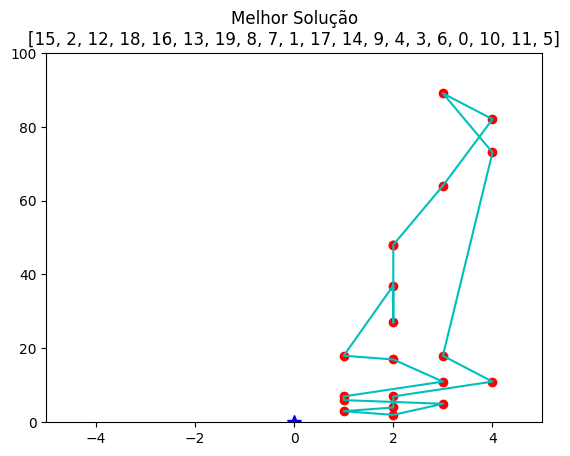

Iteração: 50


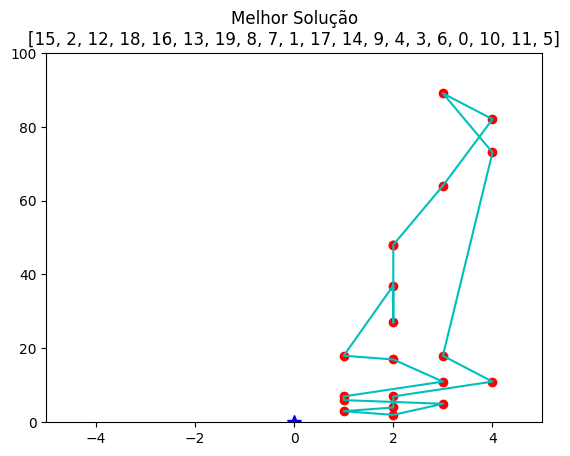

Iteração: 51


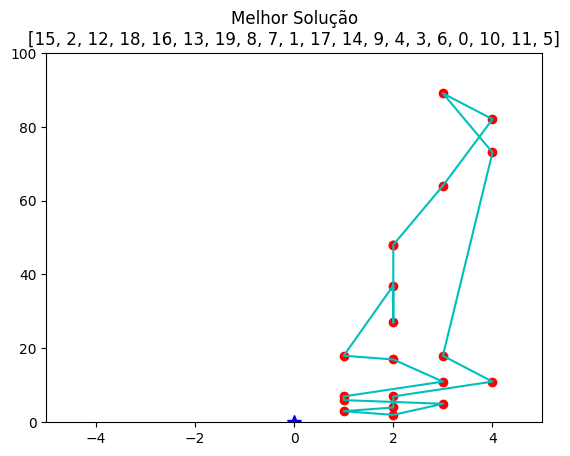

Iteração: 52


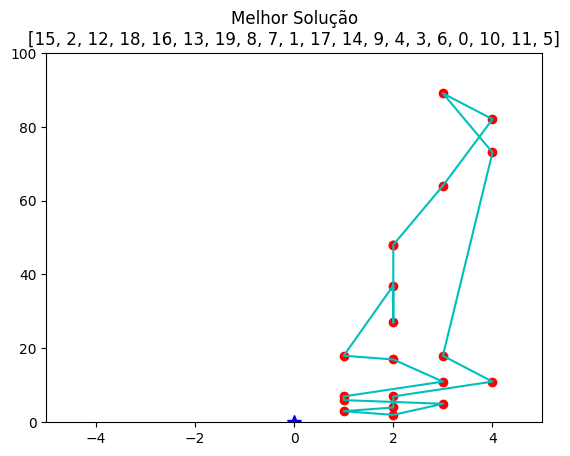

Iteração: 53


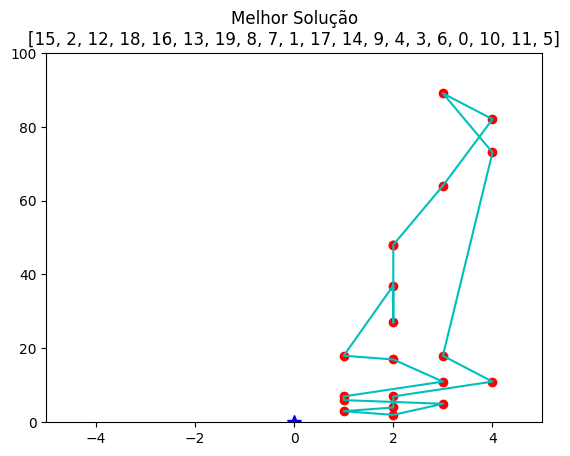

Iteração: 54


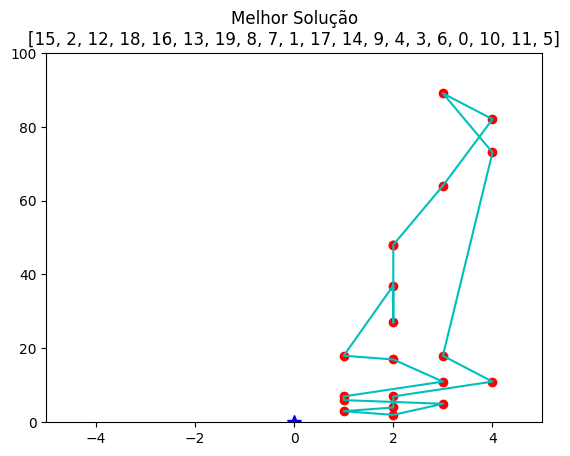

Iteração: 55


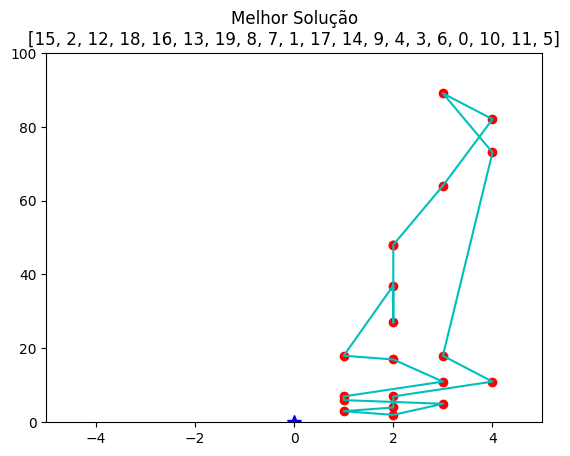

Iteração: 56


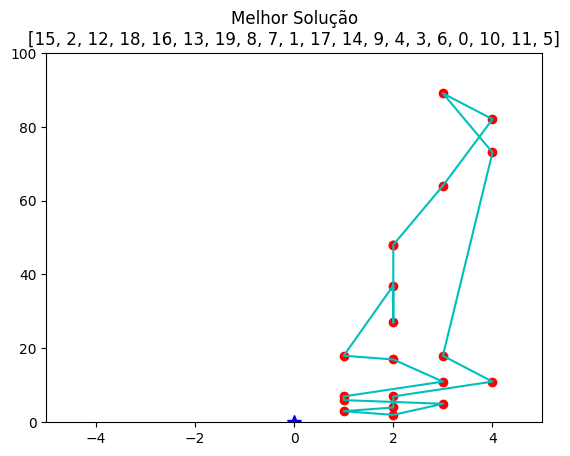

Iteração: 57


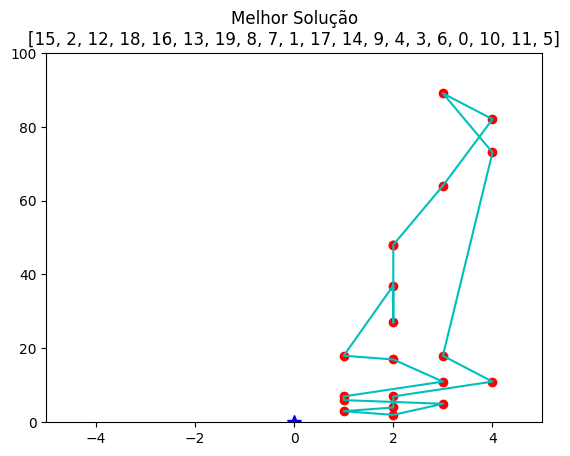

Iteração: 58


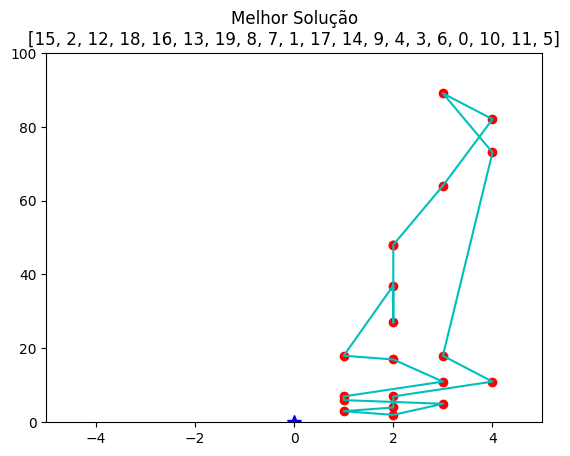

Iteração: 59


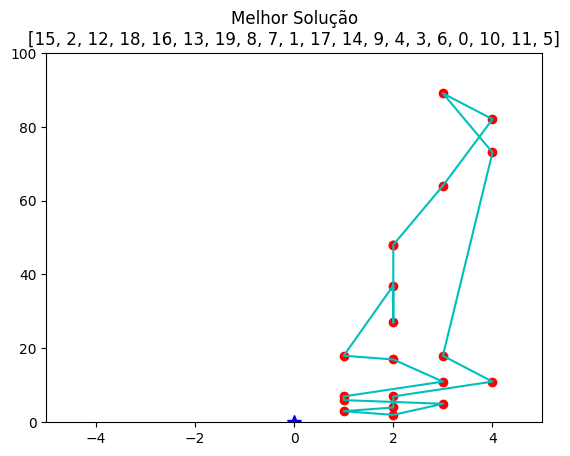

Iteração: 60


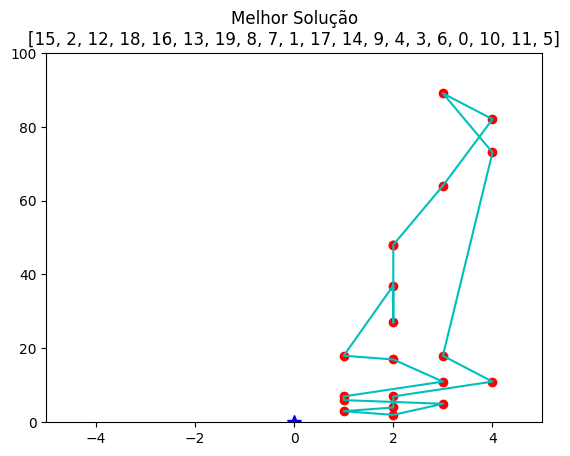

Iteração: 61


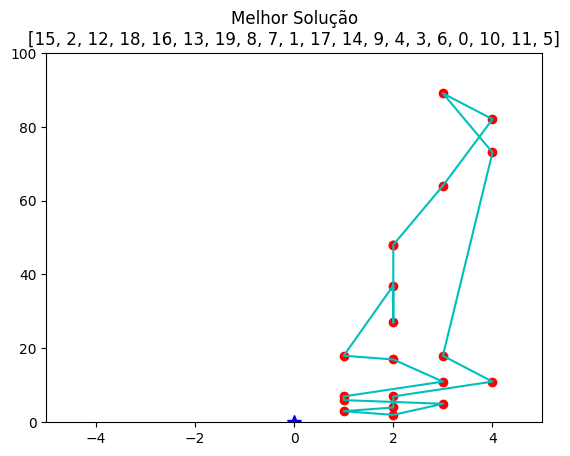

Iteração: 62


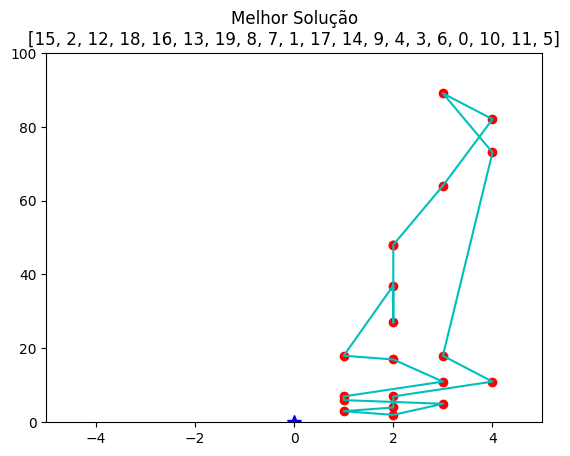

Iteração: 63


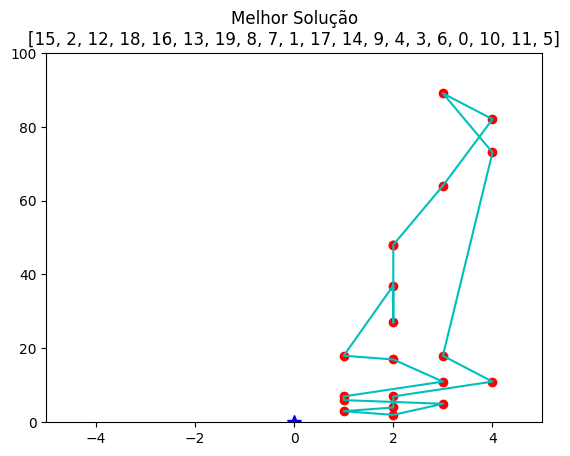

Iteração: 64


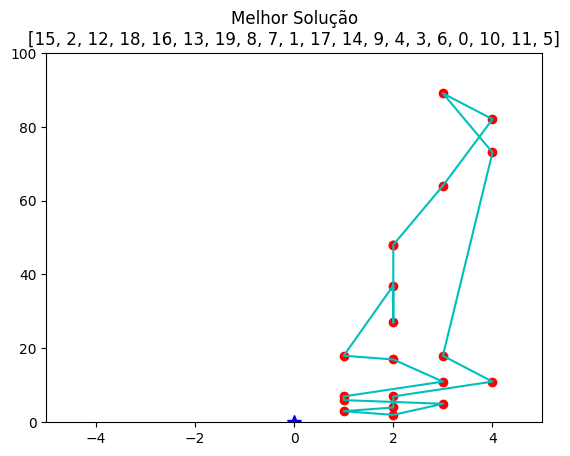

Iteração: 65


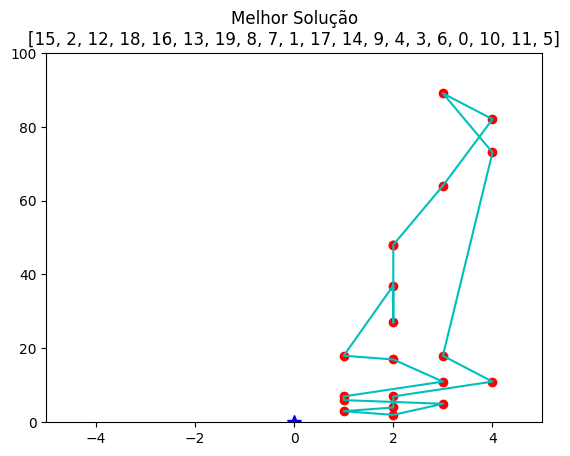

Iteração: 66


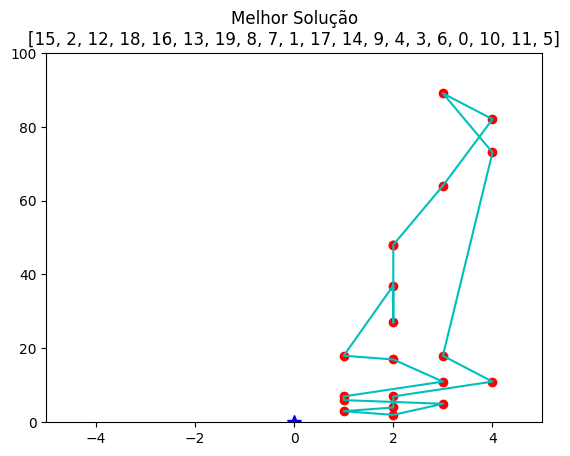

Iteração: 67


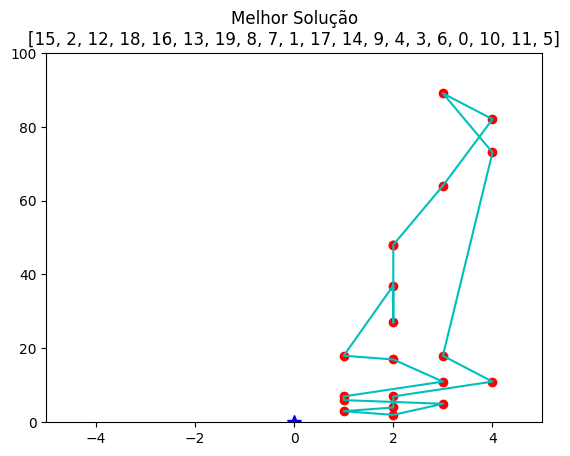

Iteração: 68


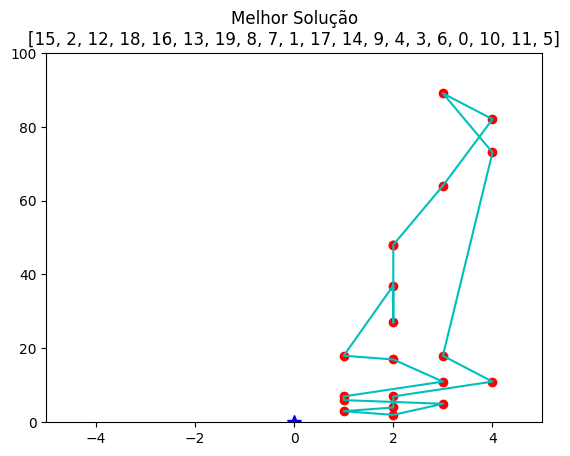

Iteração: 69


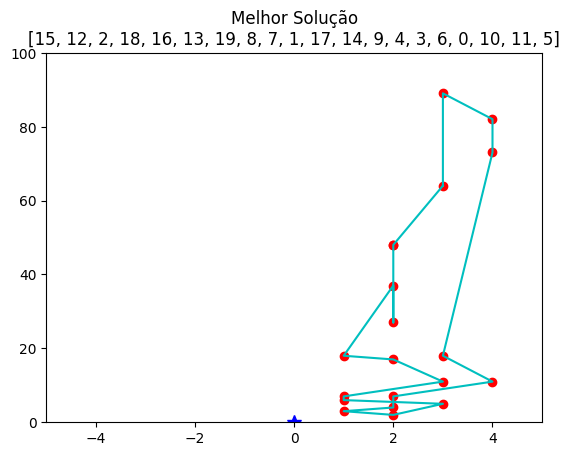

Iteração: 70


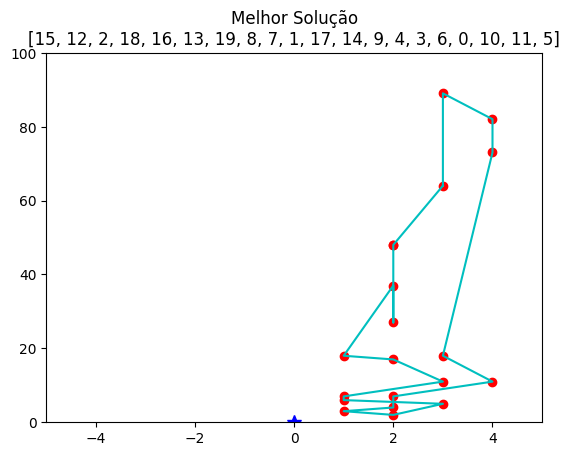

Iteração: 71


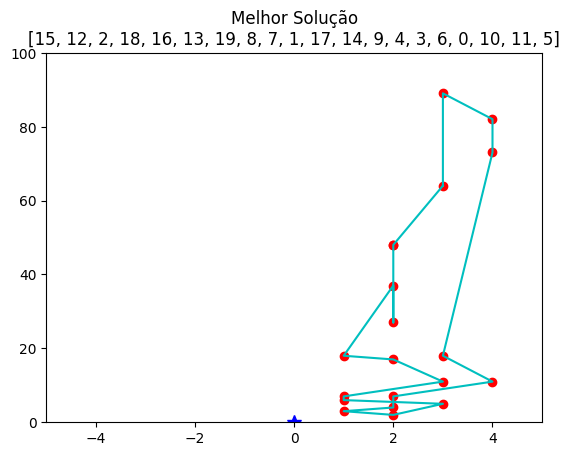

Iteração: 72


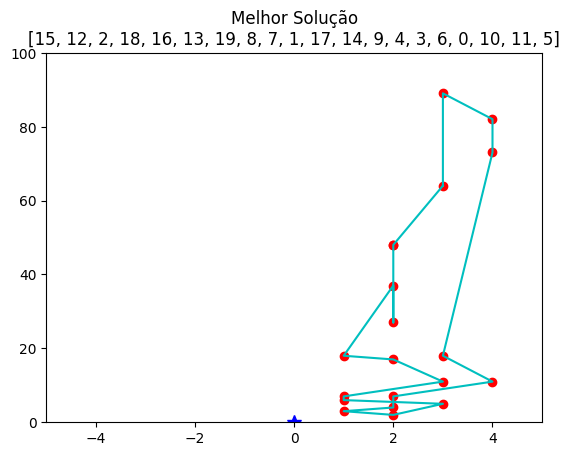

Iteração: 73


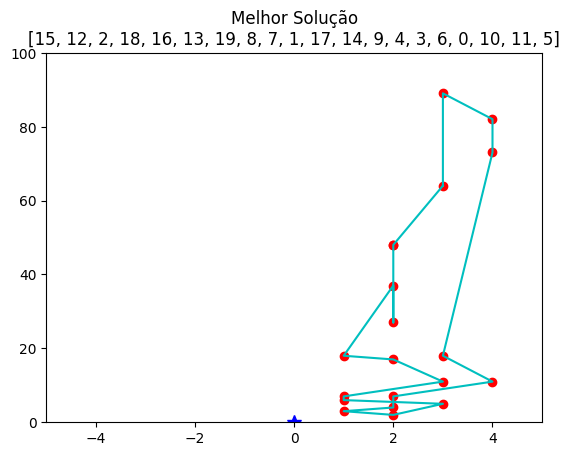

Iteração: 74


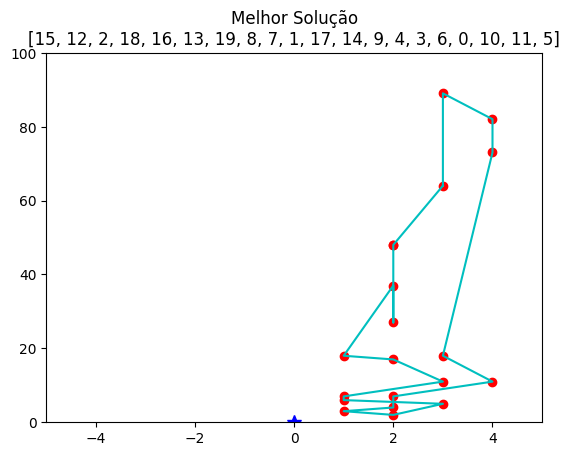

Iteração: 75


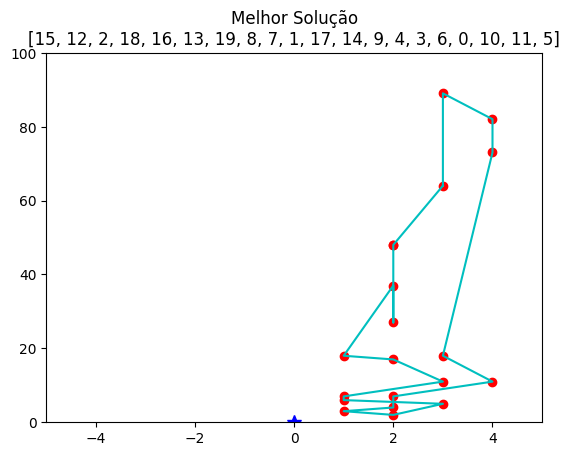

Iteração: 76


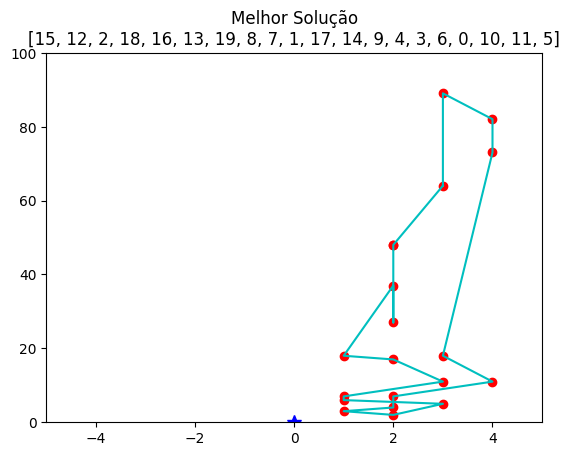

Iteração: 77


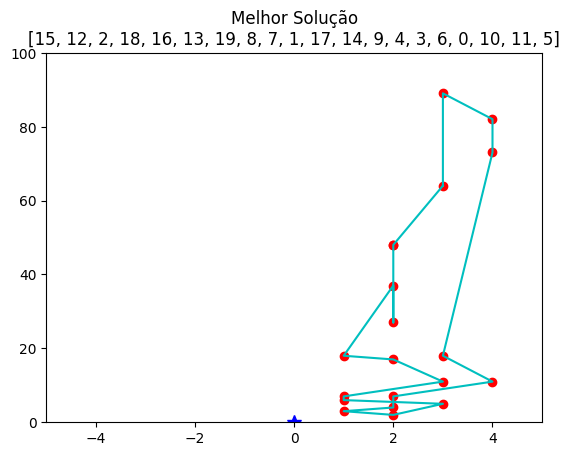

Iteração: 78


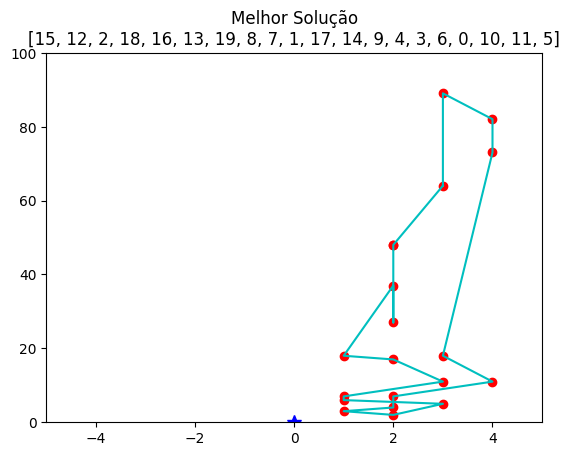

Iteração: 79


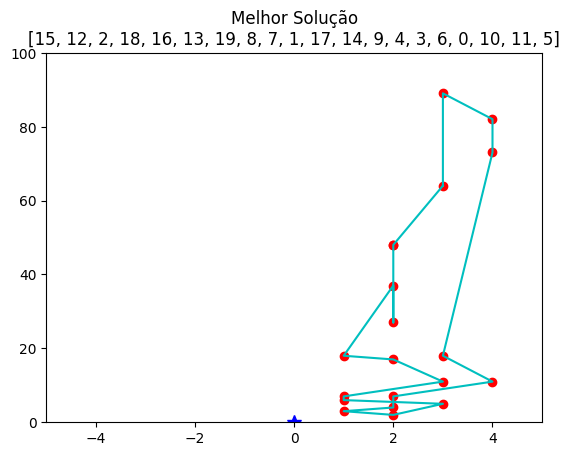

Iteração: 80


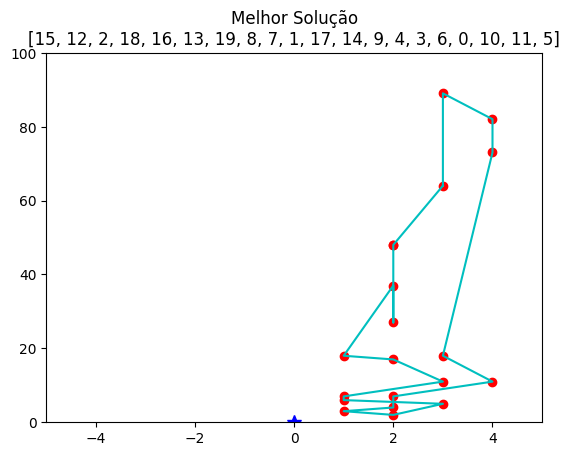

Iteração: 81


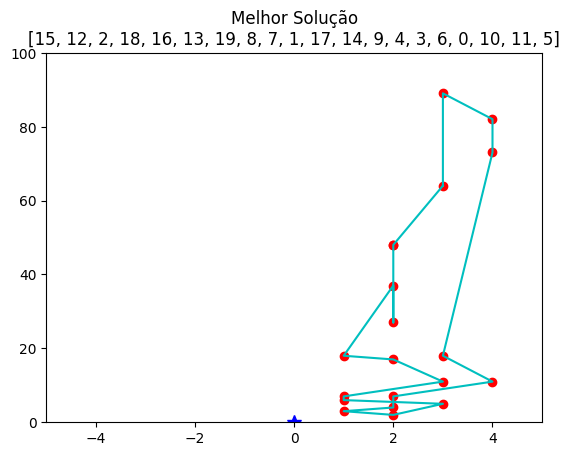

Iteração: 82


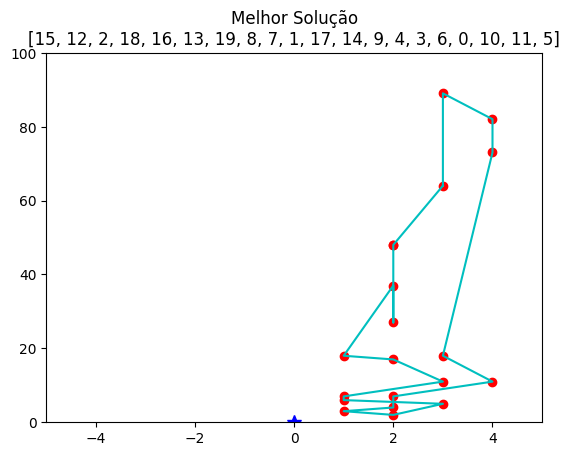

Iteração: 83


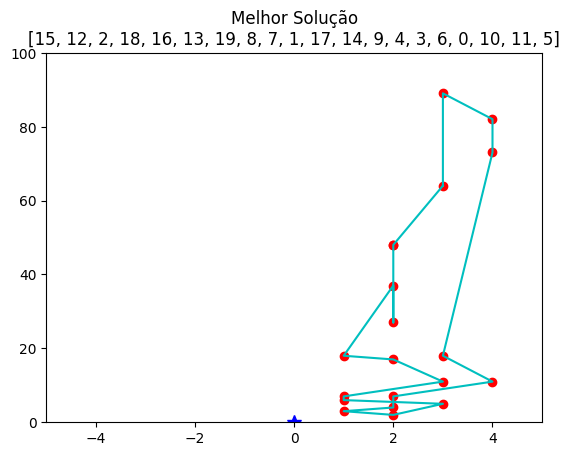

Iteração: 84


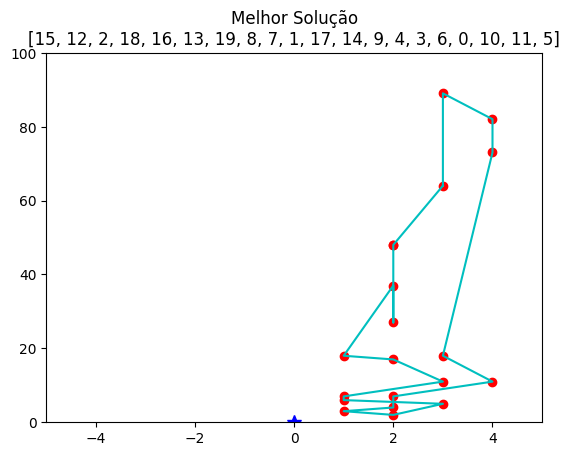

Iteração: 85


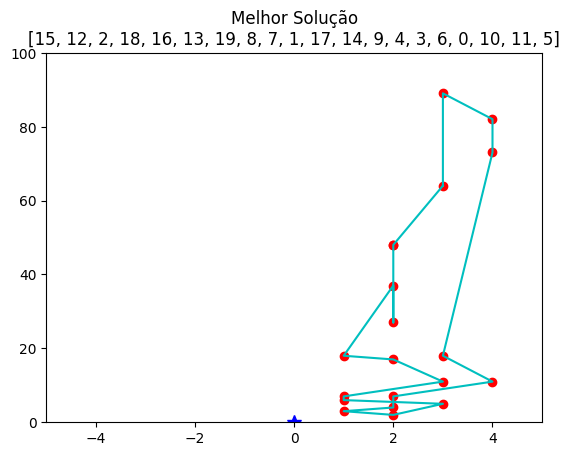

Iteração: 86


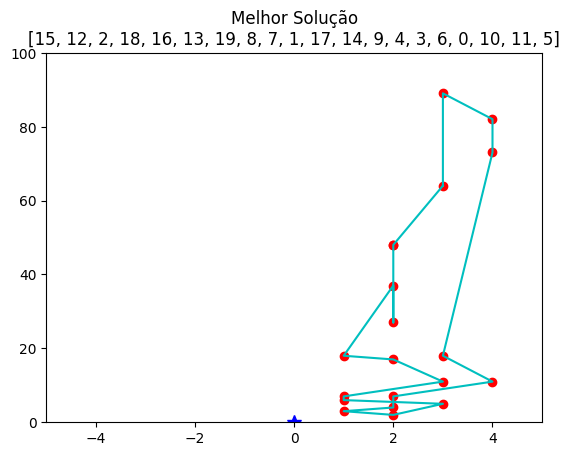

Iteração: 87


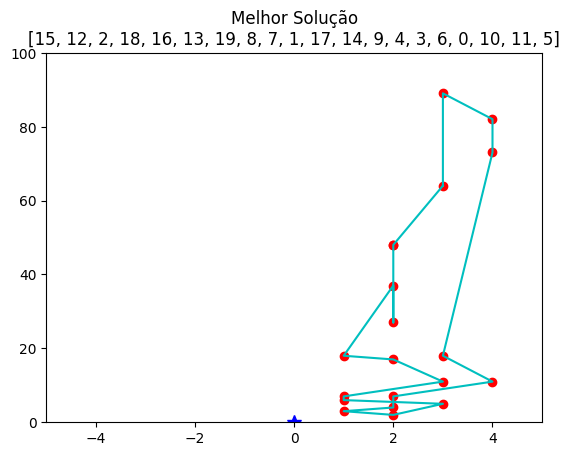

Iteração: 88


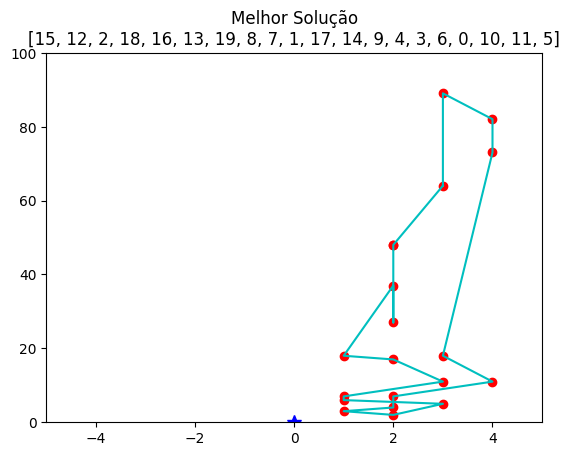

Iteração: 89


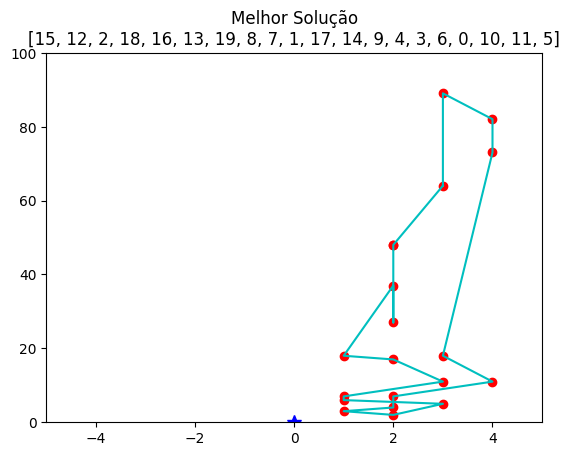

Iteração: 90


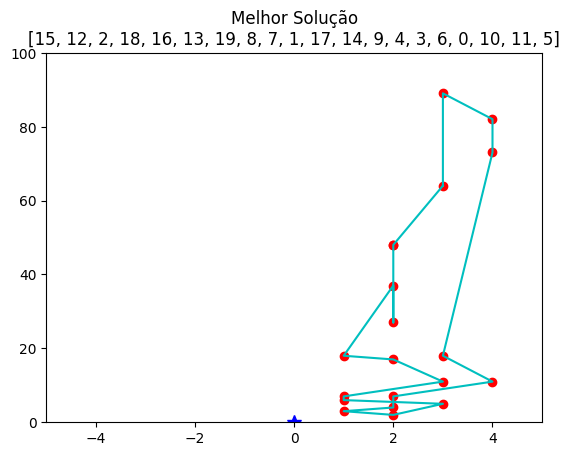

Iteração: 91


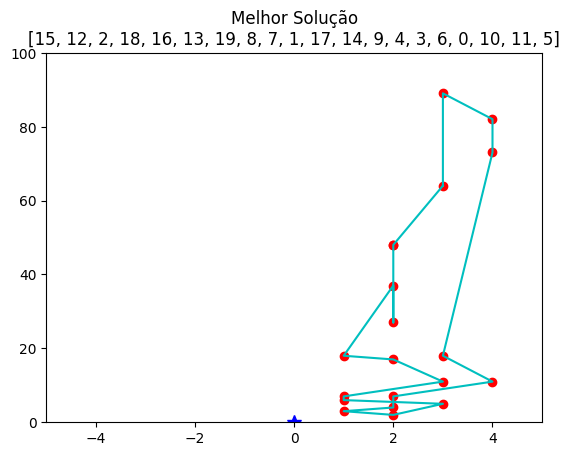

Iteração: 92


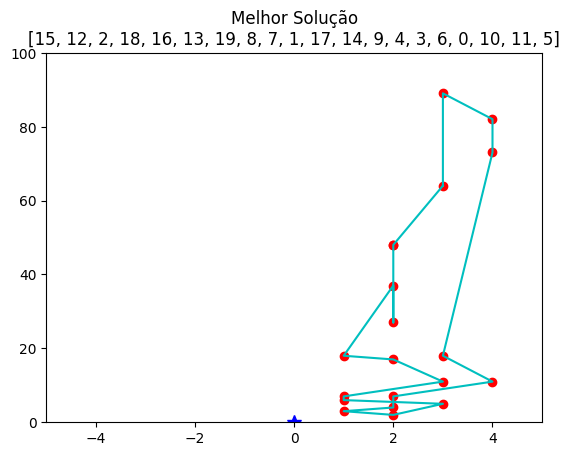

Iteração: 93


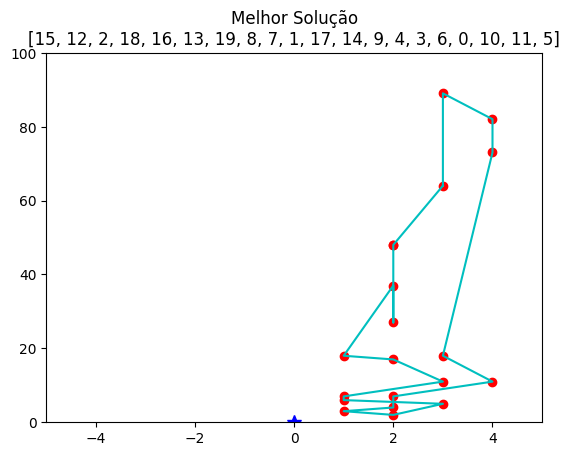

Iteração: 94


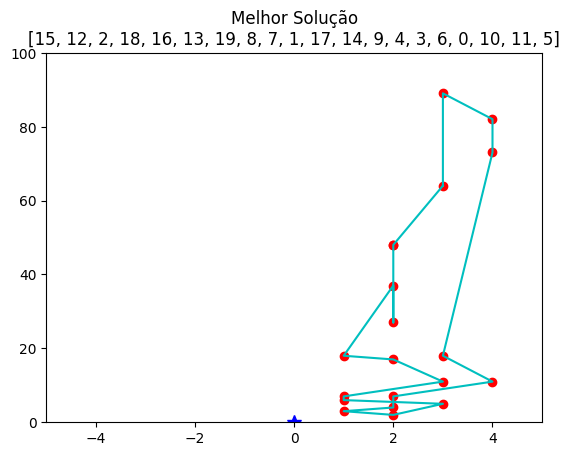

Iteração: 95


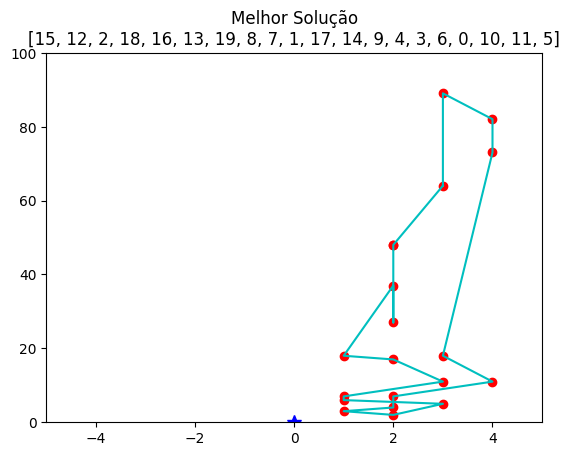

Iteração: 96


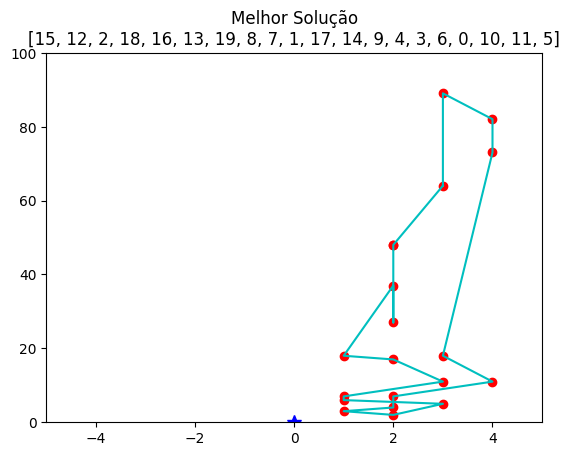

Iteração: 97


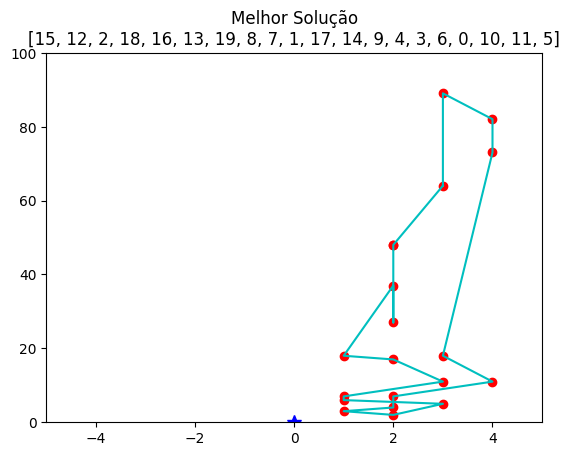

Iteração: 98


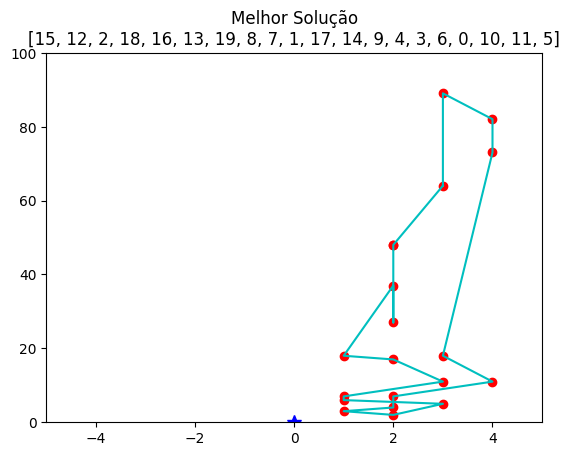

Iteração: 99


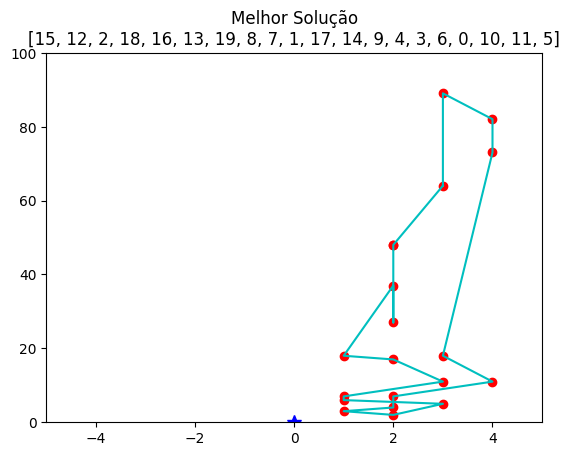

Iteração: 100


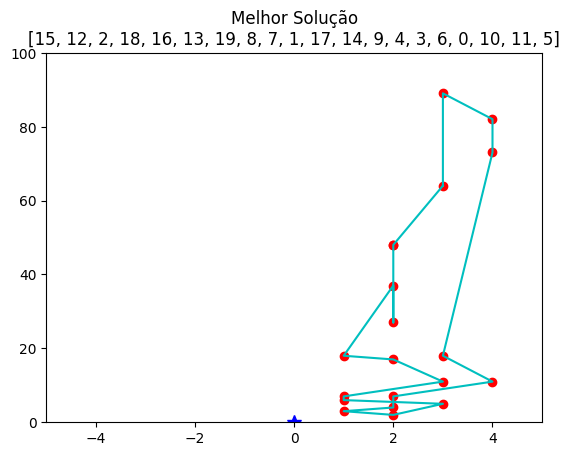

Iteração: 101


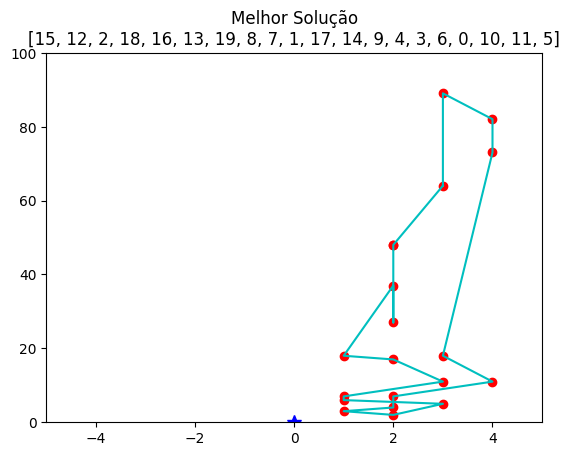

Iteração: 102


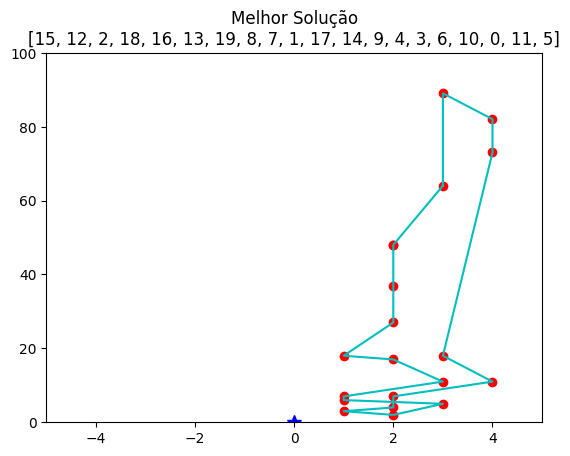

Iteração: 103


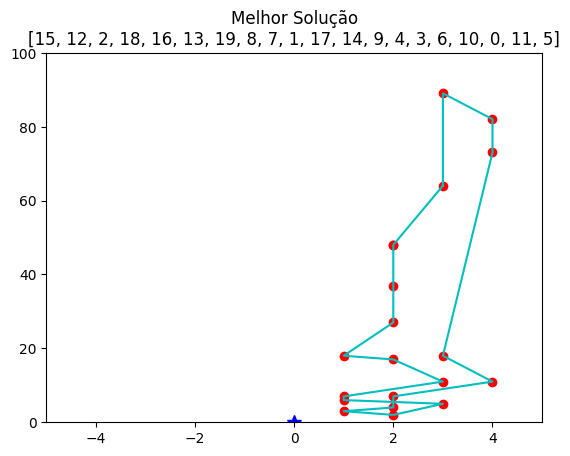

Iteração: 104


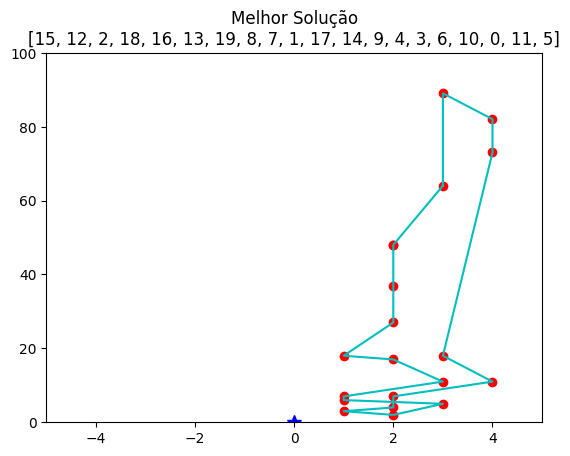

Iteração: 105


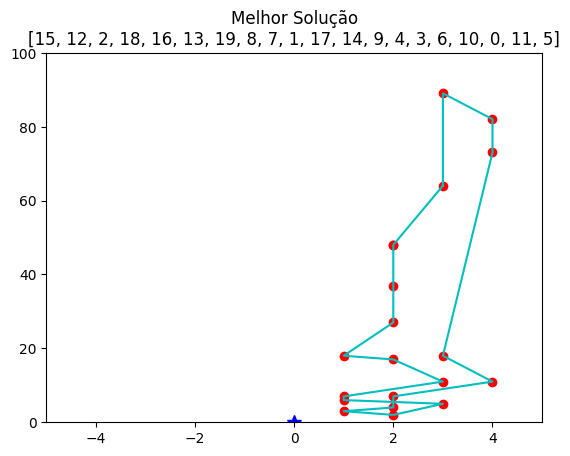

Iteração: 106


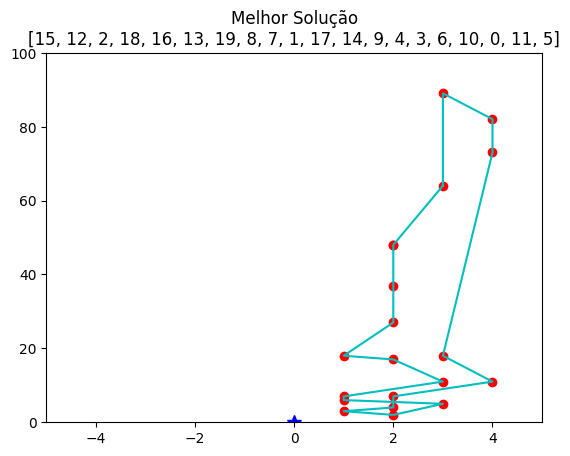

Iteração: 107


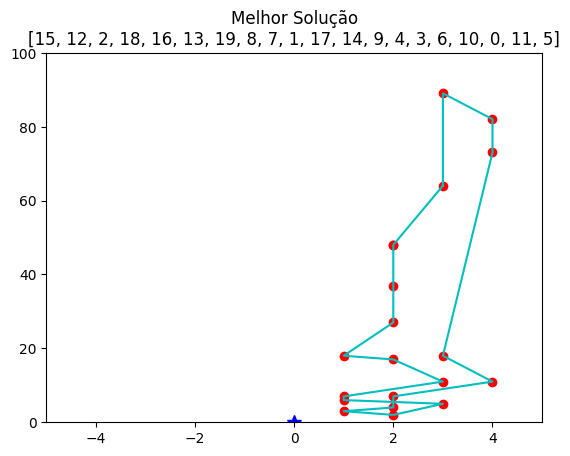

Iteração: 108


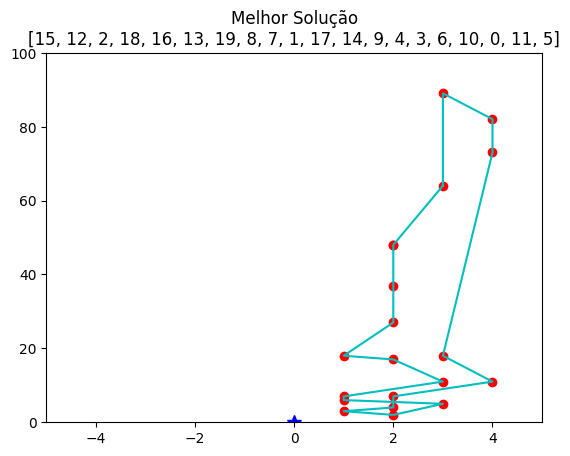

Iteração: 109


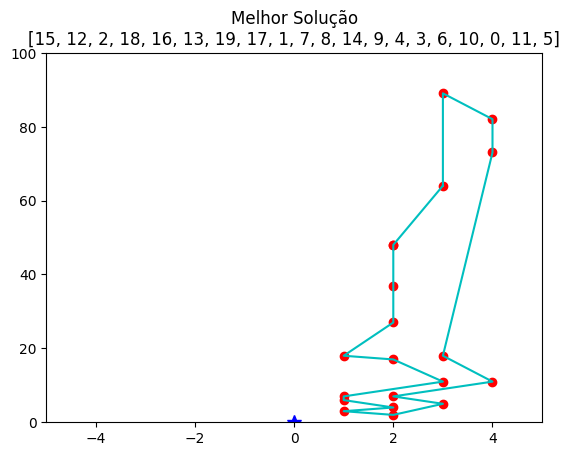

Iteração: 110


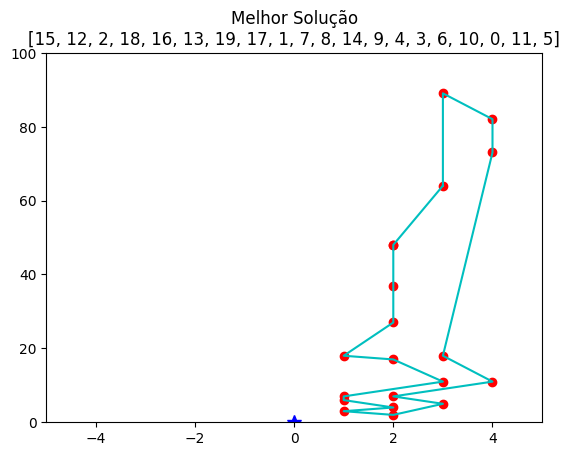

Iteração: 111


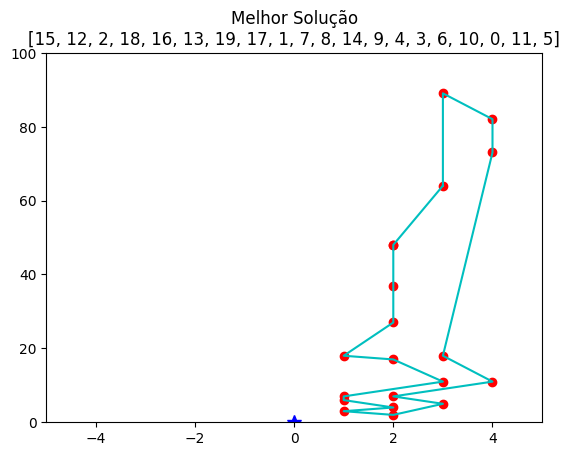

Iteração: 112


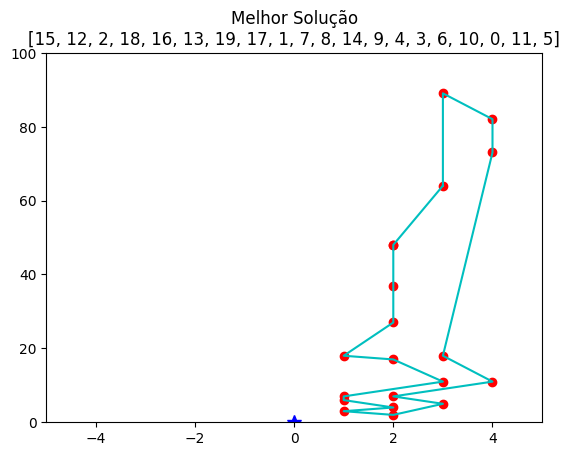

Iteração: 113


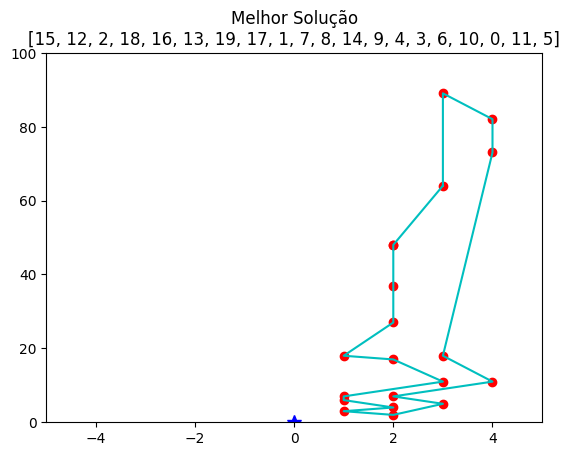

Iteração: 114


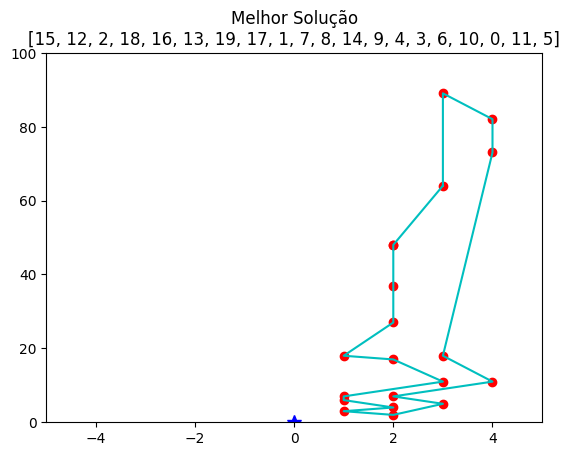

Iteração: 115


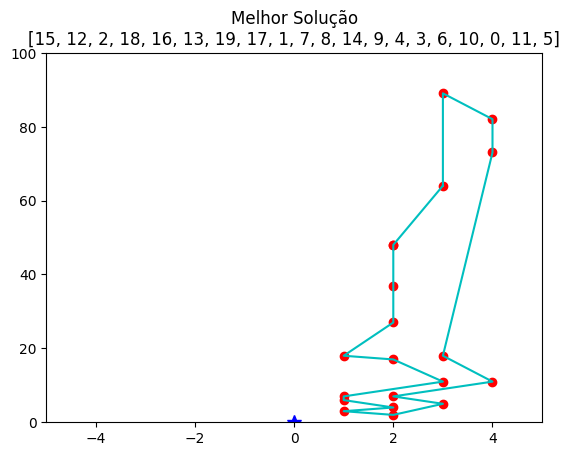

Iteração: 116


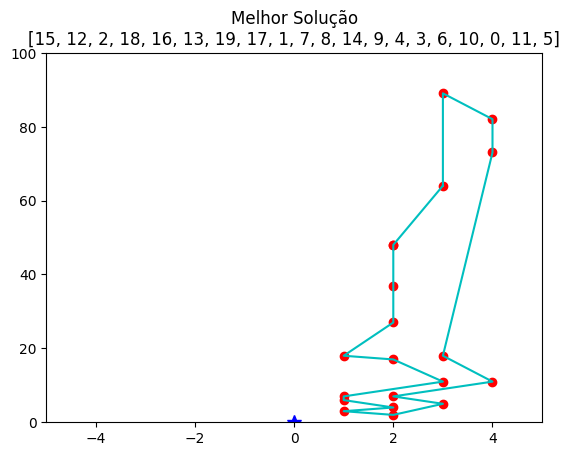

Iteração: 117


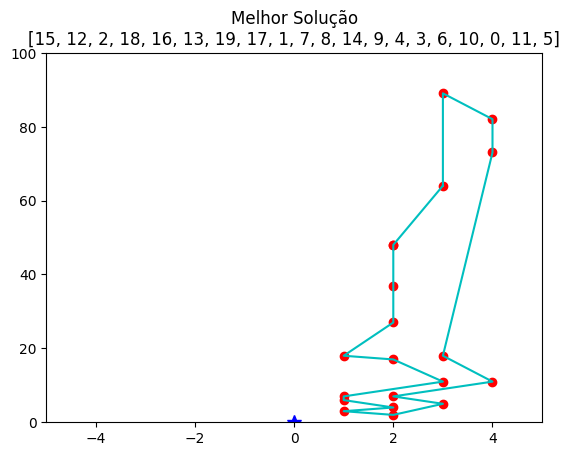

Iteração: 118


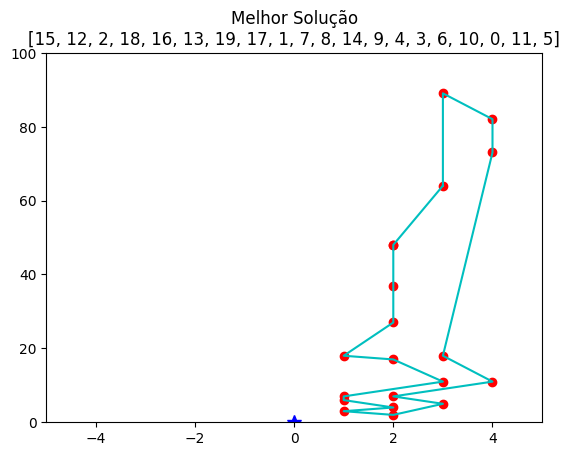

Iteração: 119


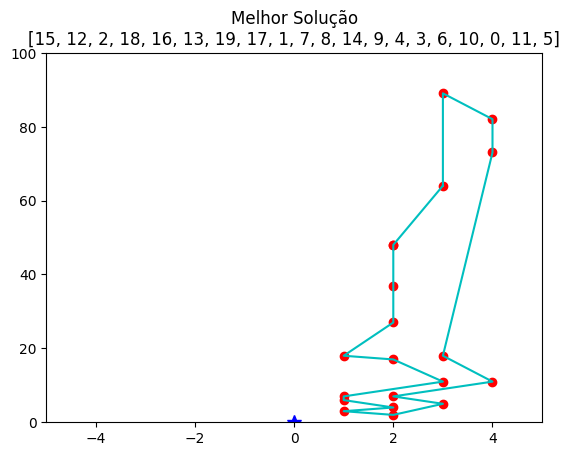

Iteração: 120


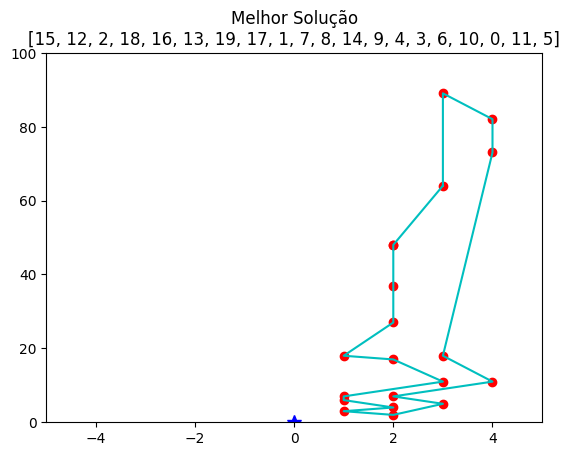

Iteração: 121


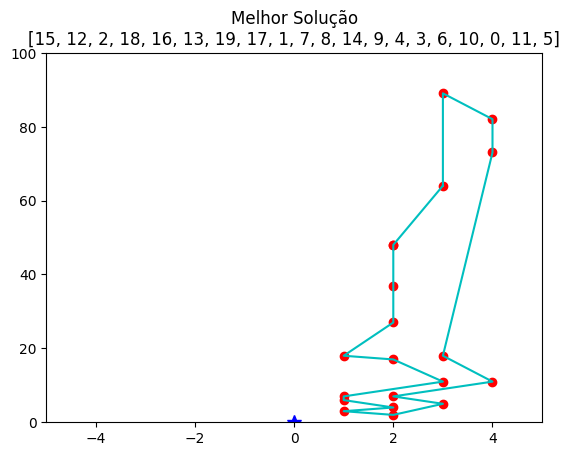

Iteração: 122


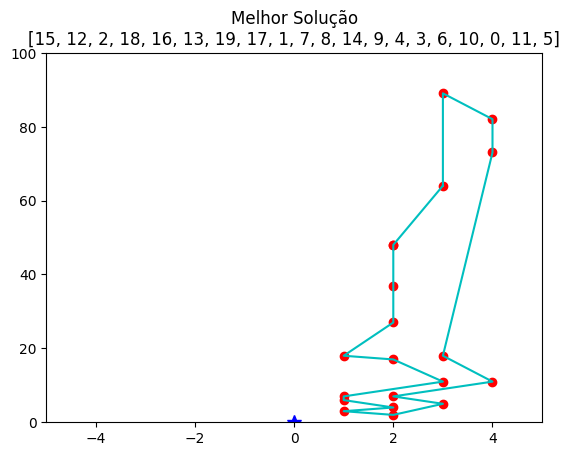

Iteração: 123


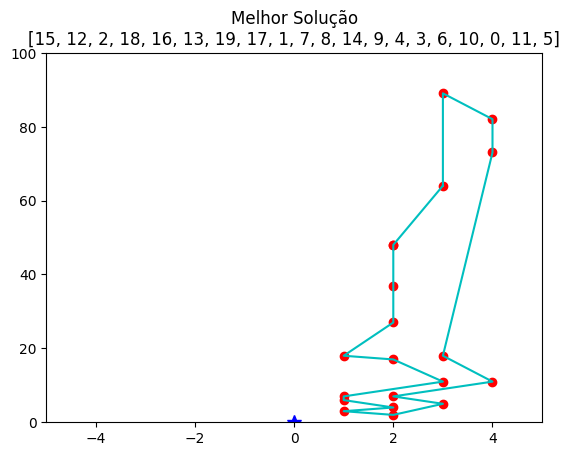

Iteração: 124


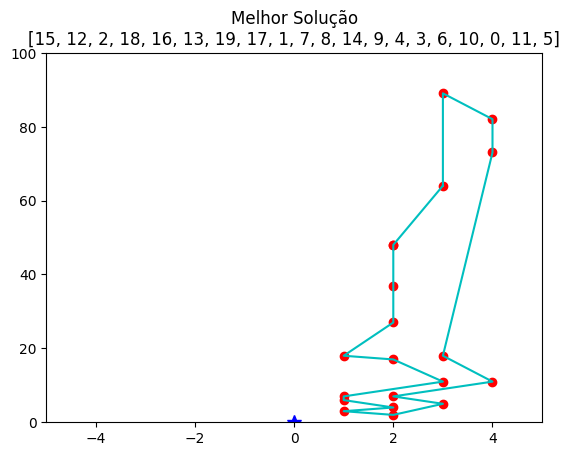

Iteração: 125


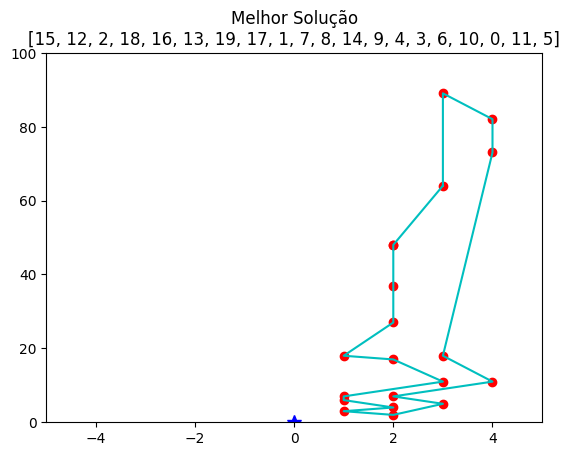

Iteração: 126


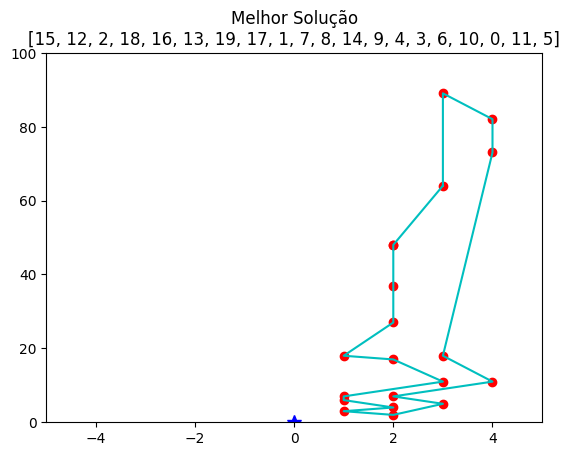

Iteração: 127


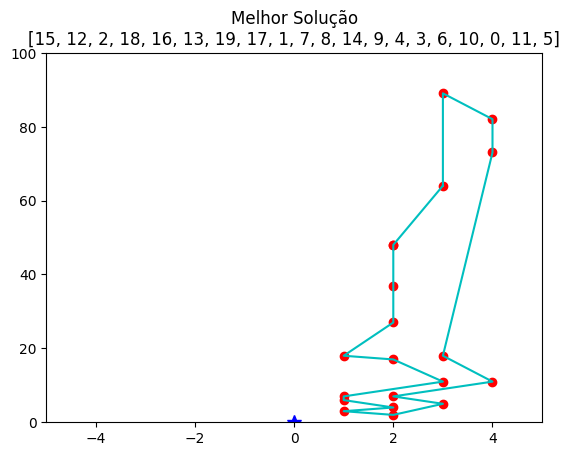

Iteração: 128


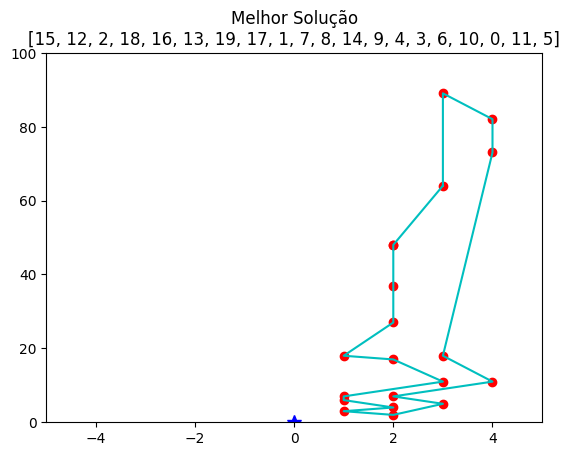

Iteração: 129


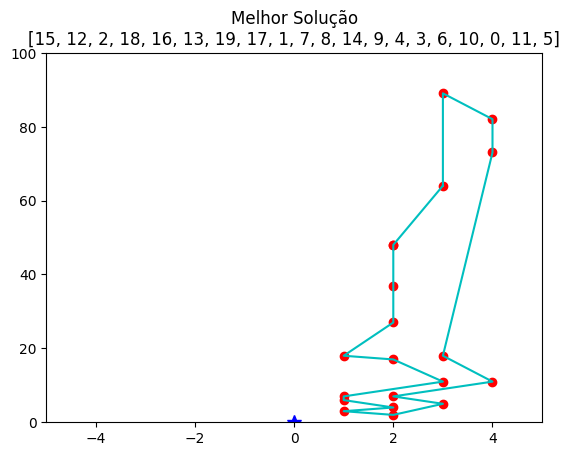

Iteração: 130


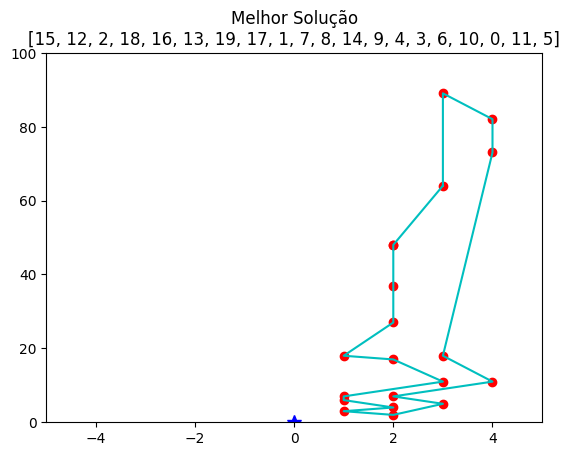

Iteração: 131


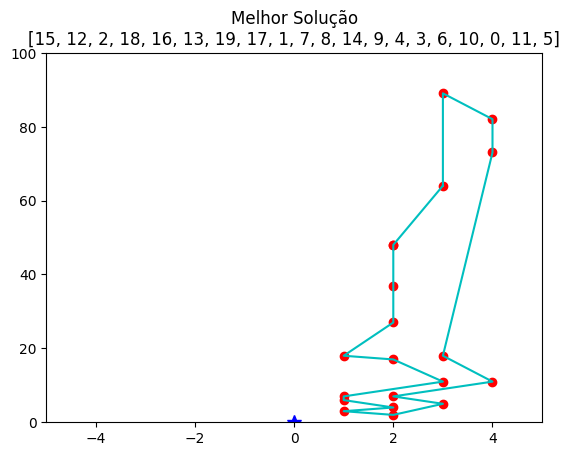

Iteração: 132


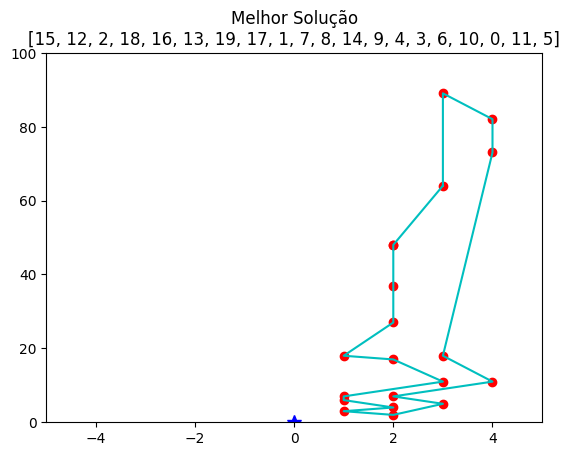

Iteração: 133


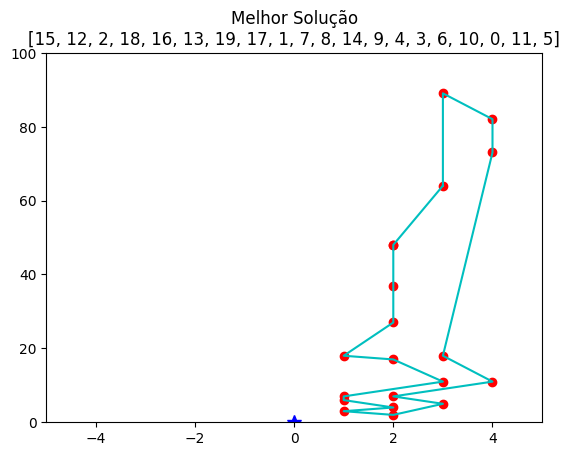

Iteração: 134


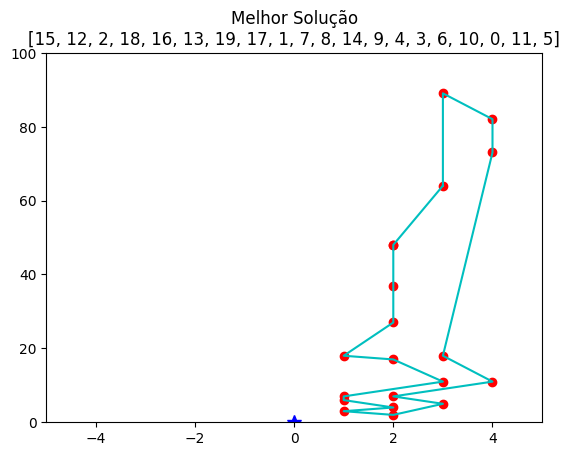

Iteração: 135


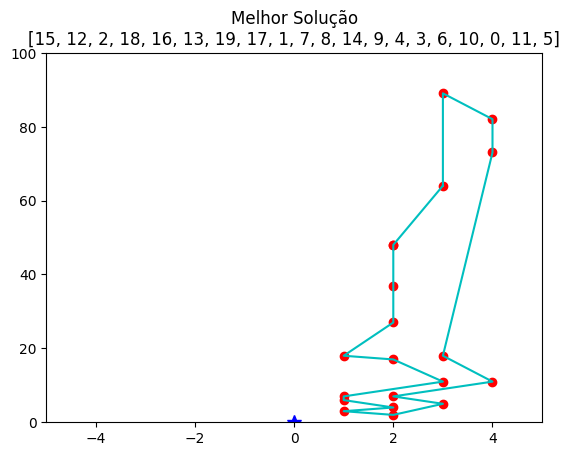

Iteração: 136


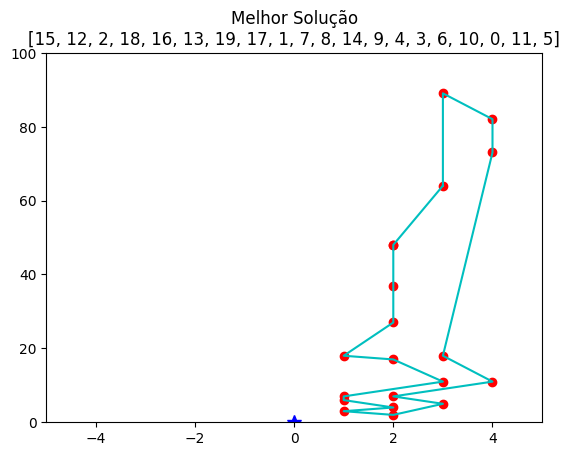

Iteração: 137


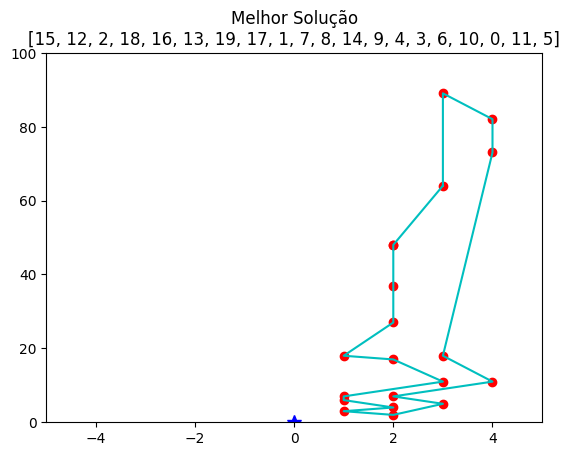

Iteração: 138


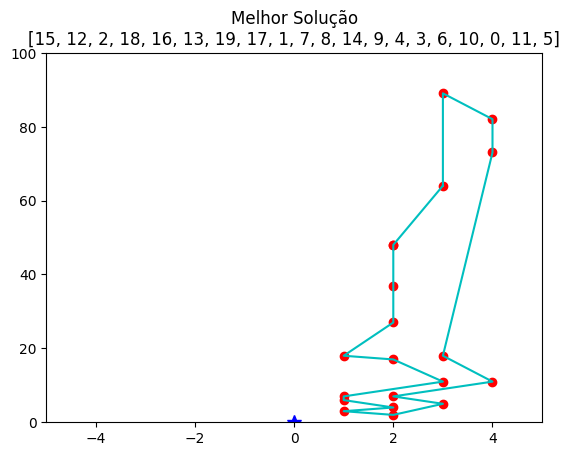

Iteração: 139


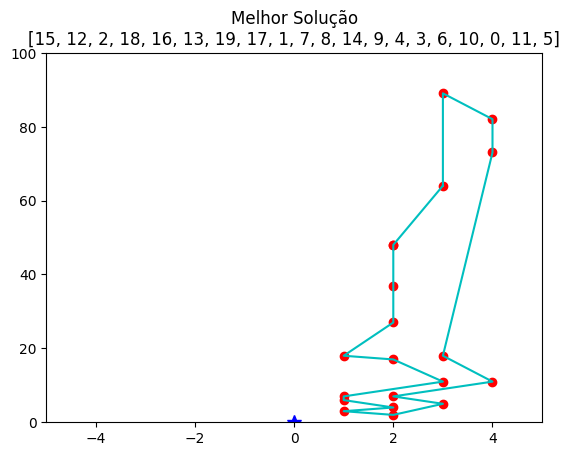

Iteração: 140


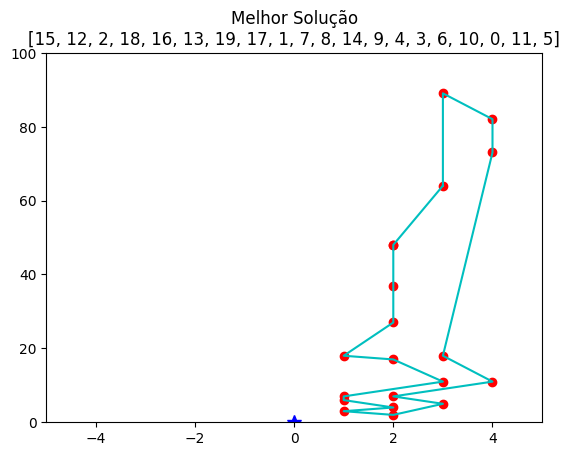

Iteração: 141


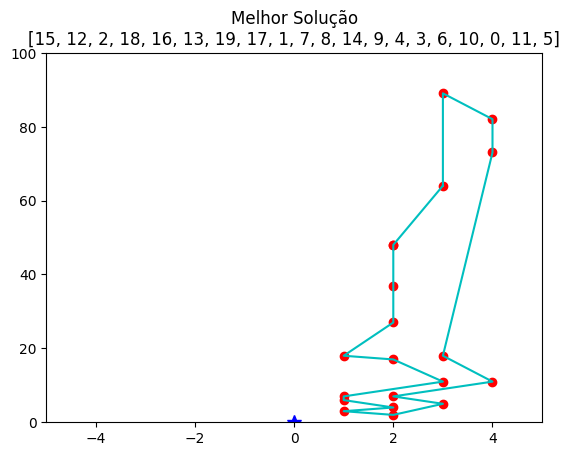

Iteração: 142


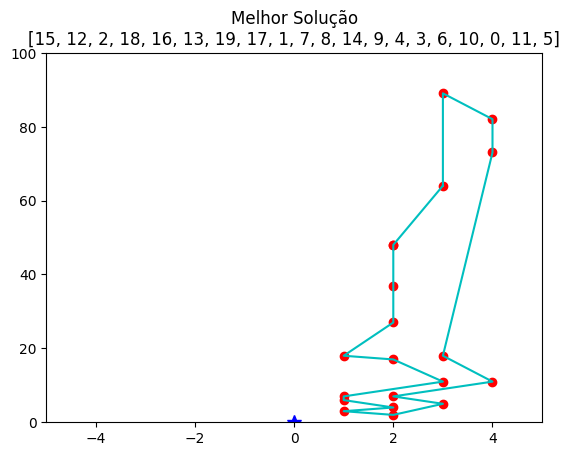

Iteração: 143


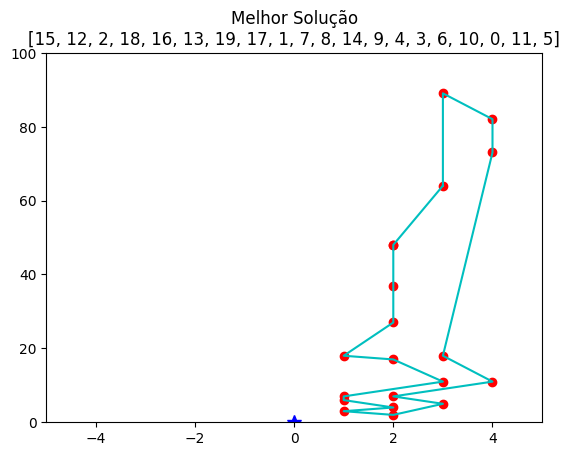

Iteração: 144


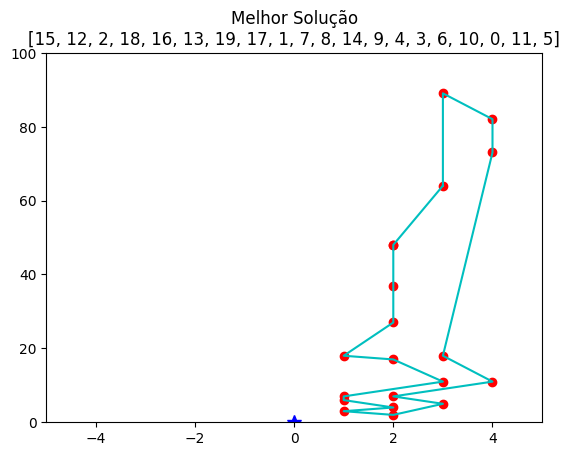

Iteração: 145


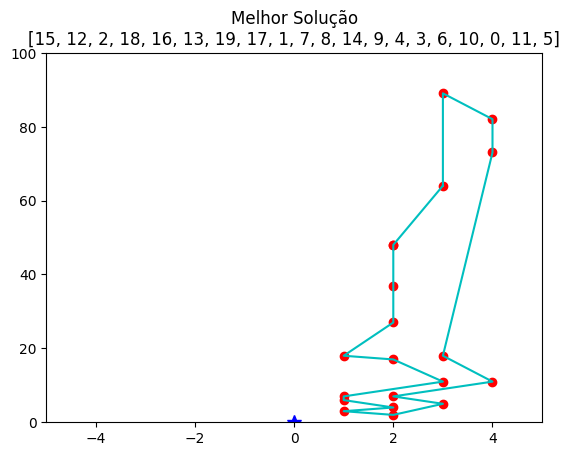

Iteração: 146


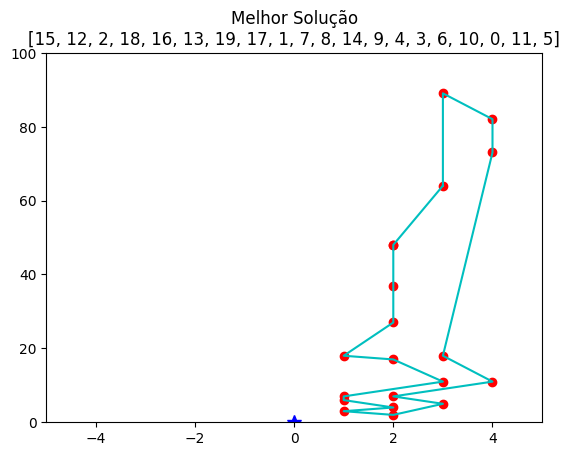

Iteração: 147


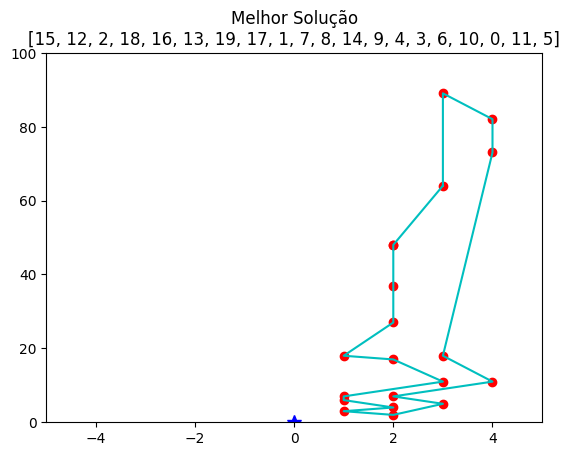

Iteração: 148


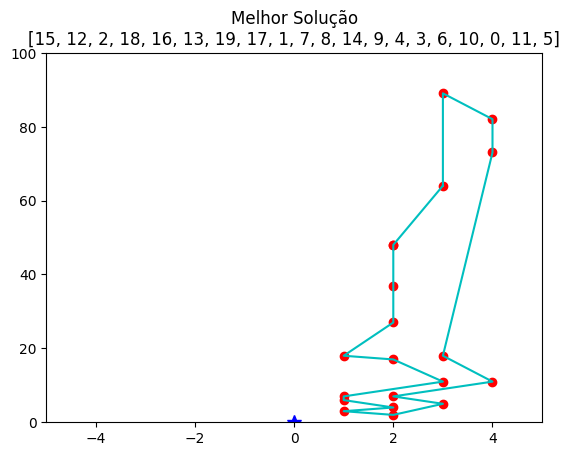

Iteração: 149


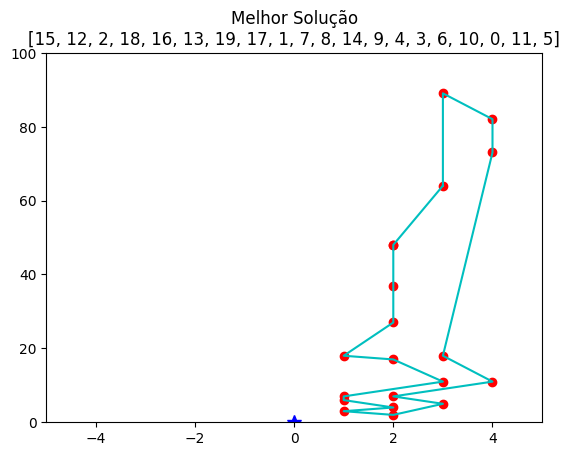

Iteração: 150


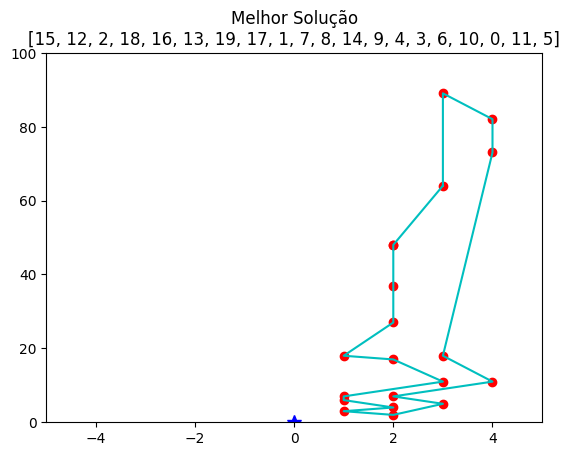

Iteração: 151


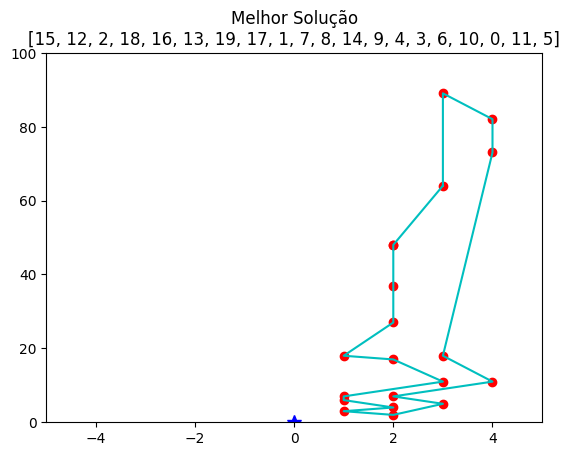

Iteração: 152


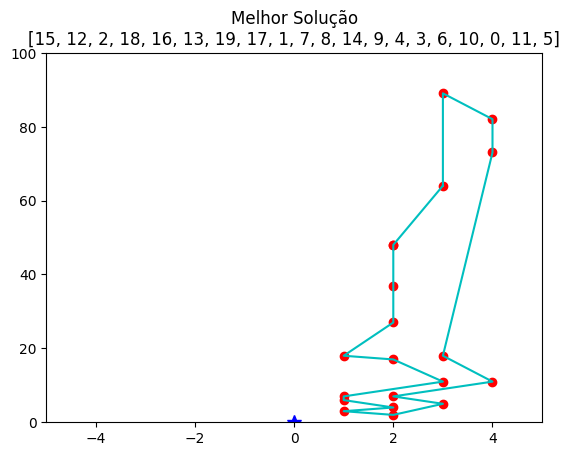

Iteração: 153


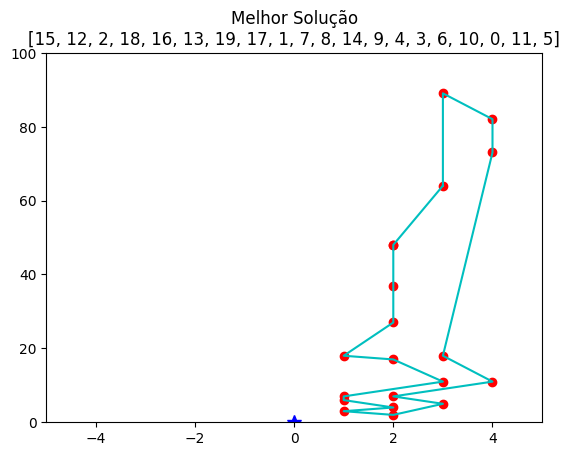

Iteração: 154


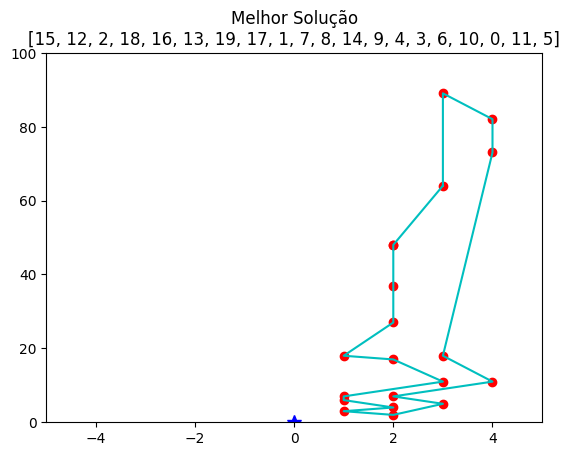

Iteração: 155


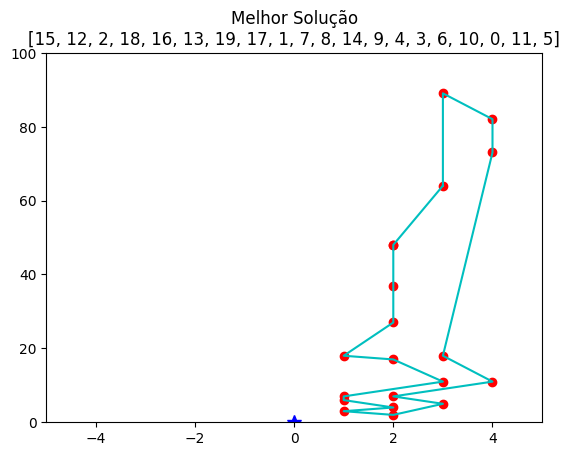

Iteração: 156


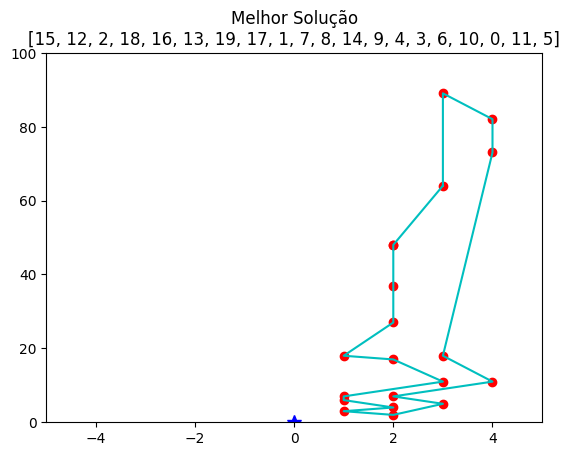

Iteração: 157


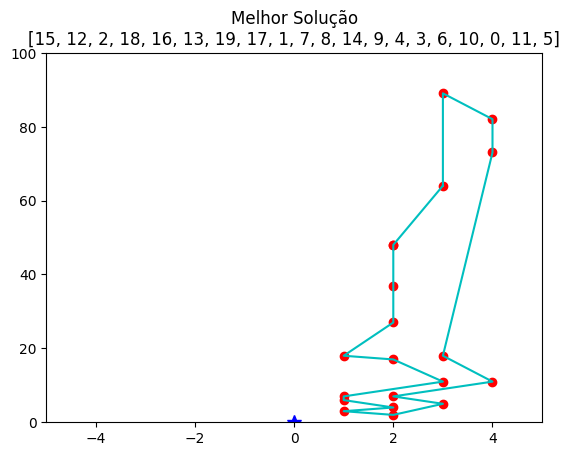

Iteração: 158


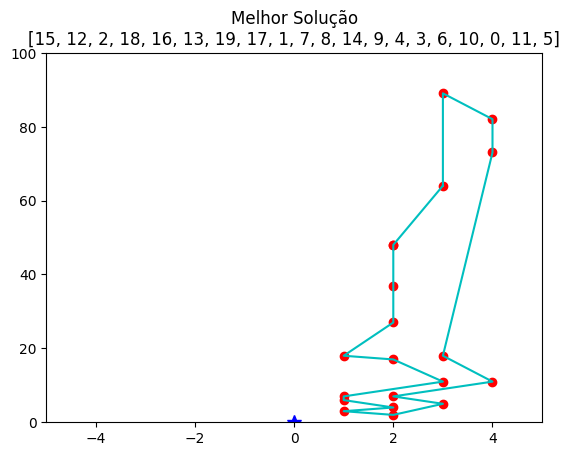

Iteração: 159


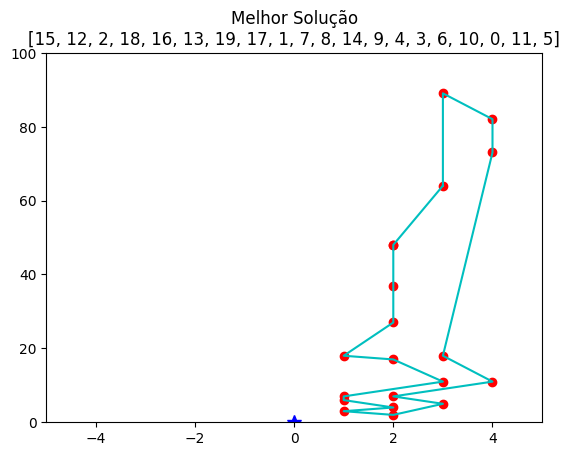

Iteração: 160


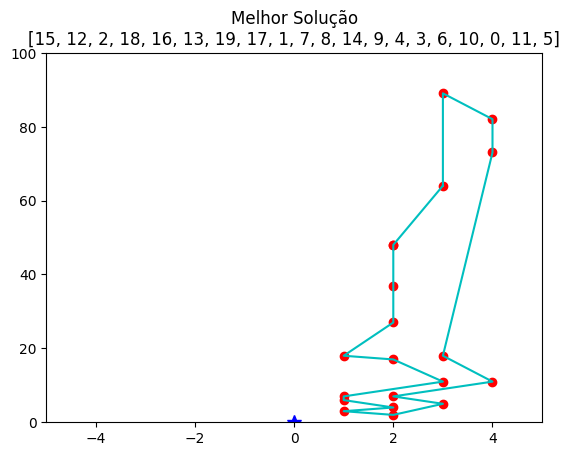

Iteração: 161


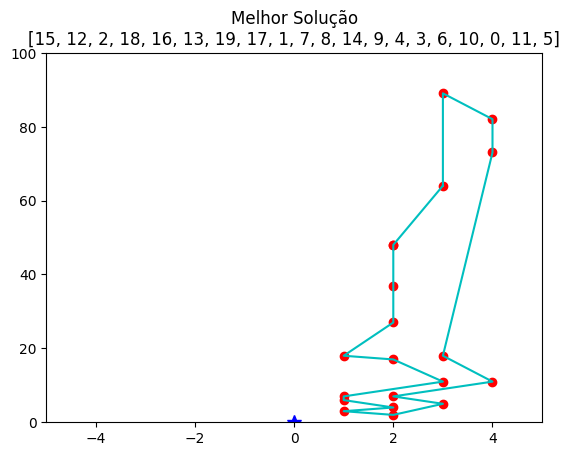

Iteração: 162


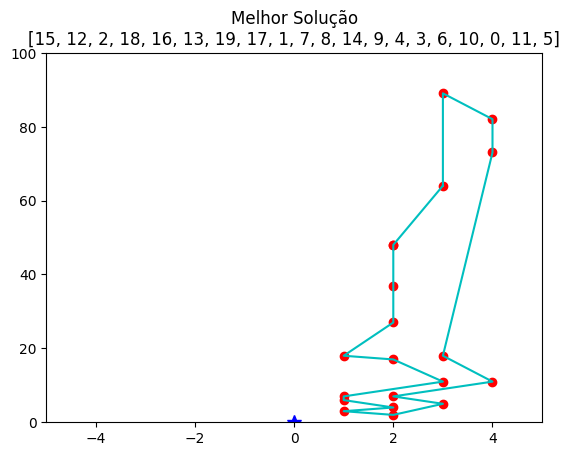

Iteração: 163


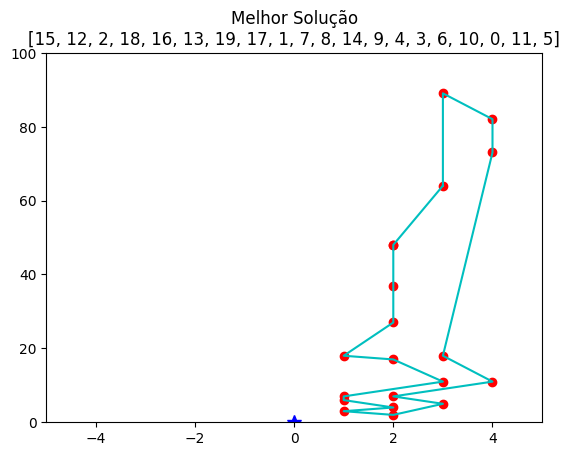

Iteração: 164


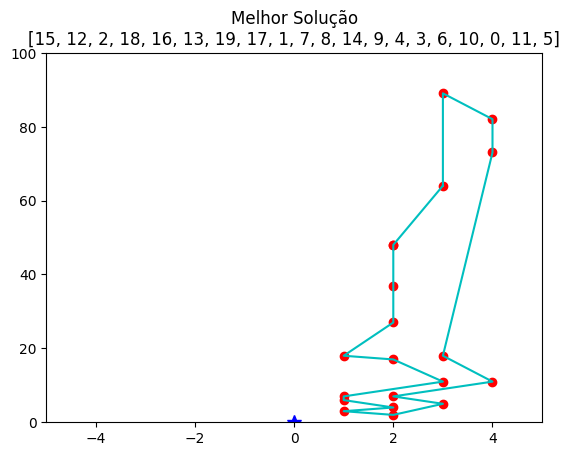

Iteração: 165


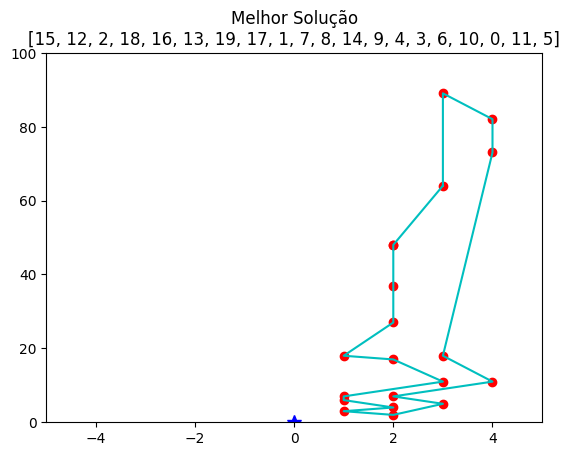

Iteração: 166


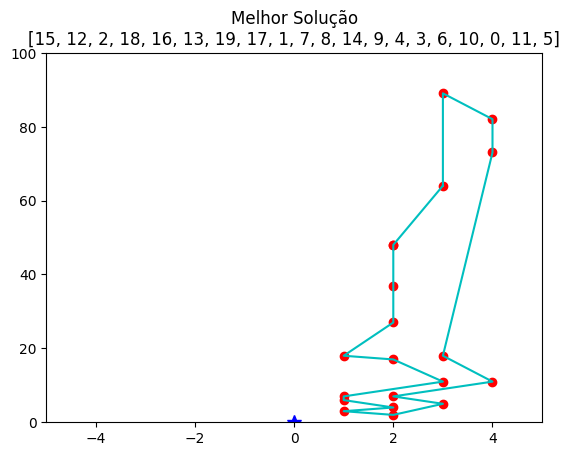

Iteração: 167


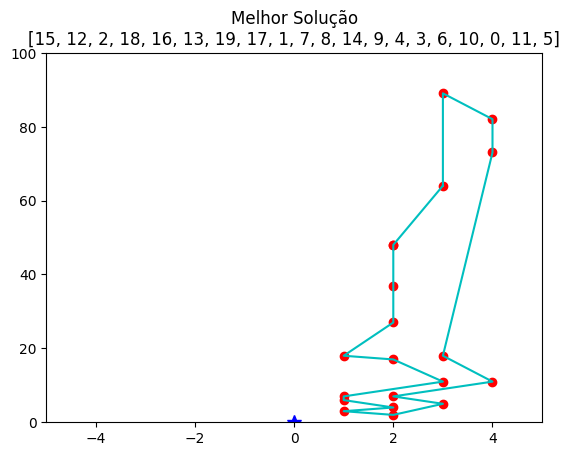

Iteração: 168


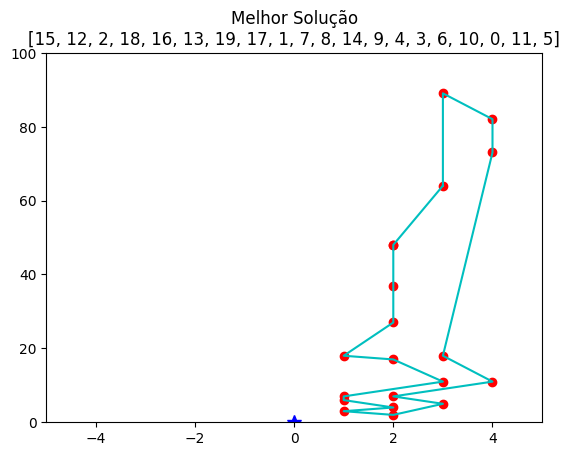

Iteração: 169


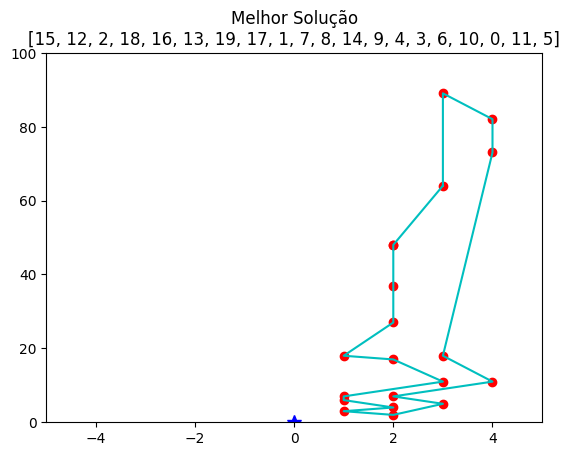

Iteração: 170


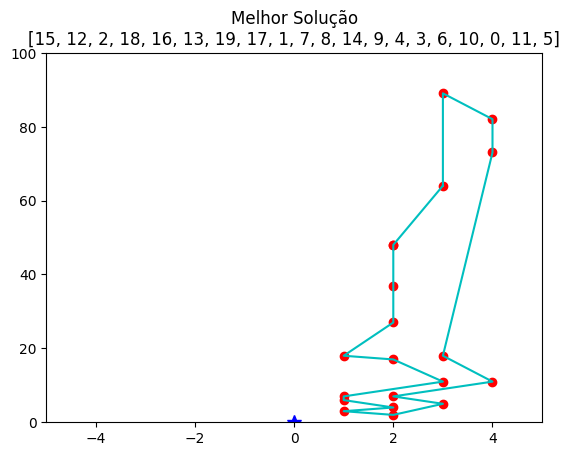

Iteração: 171


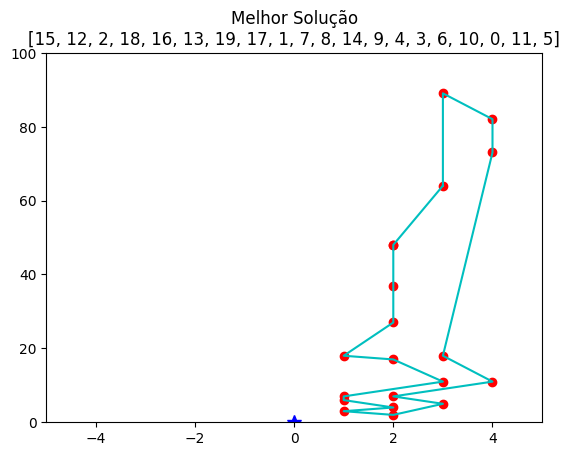

Iteração: 172


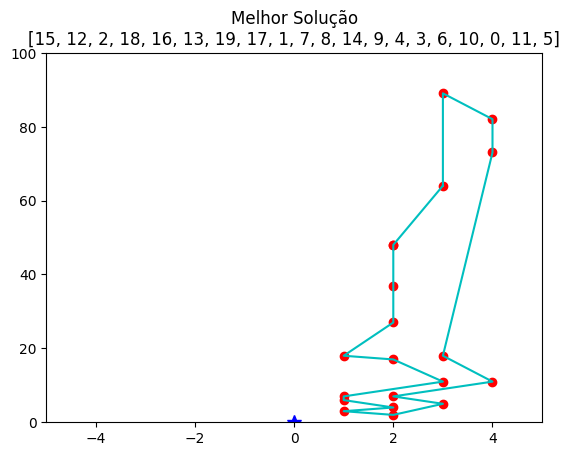

Iteração: 173


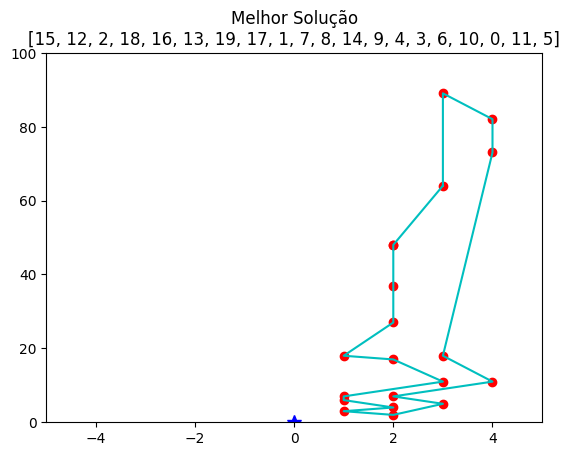

Iteração: 174


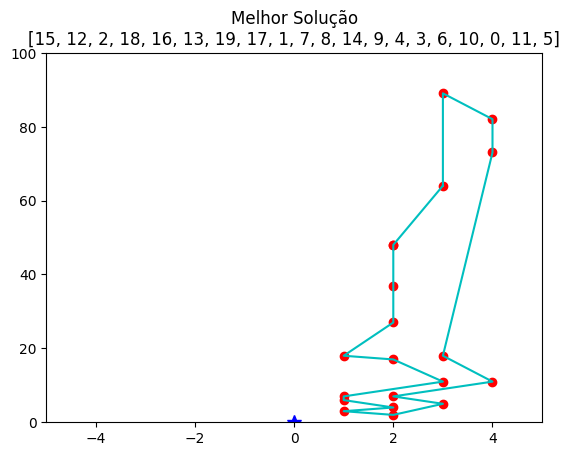

Iteração: 175


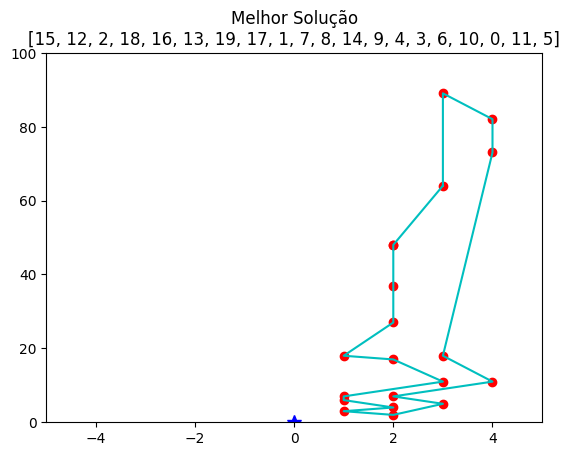

Iteração: 176


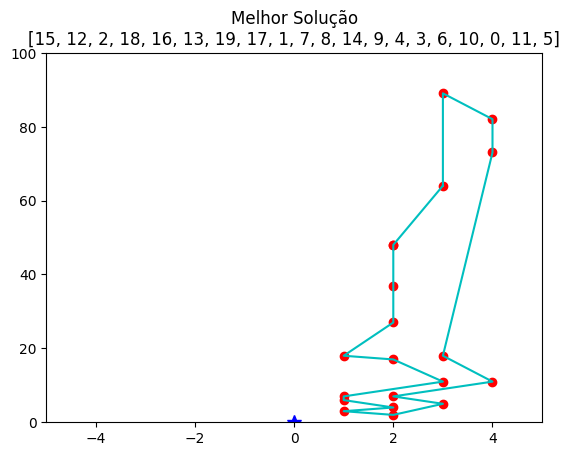

Iteração: 177


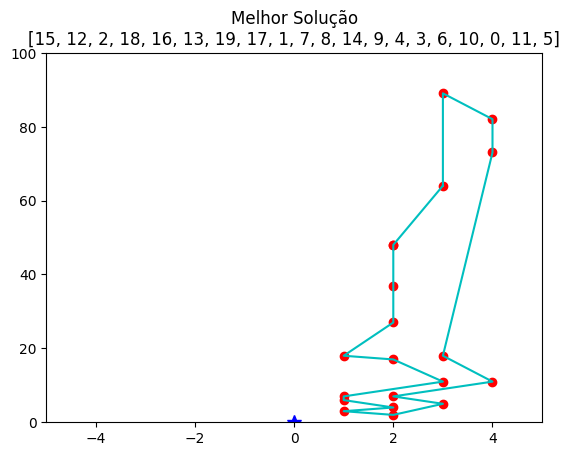

Iteração: 178


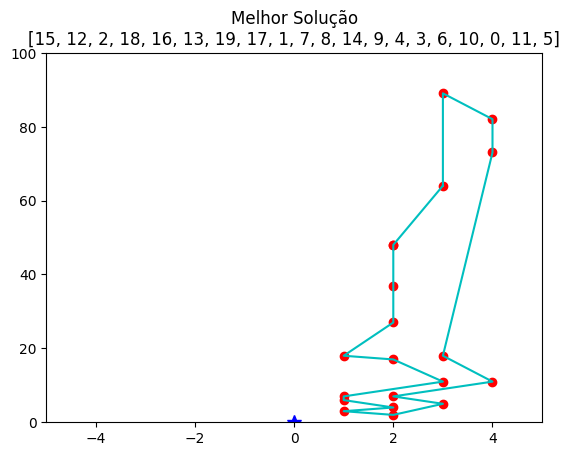

Iteração: 179


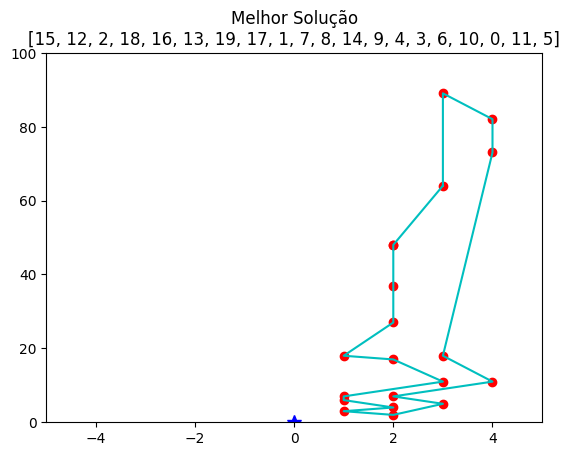

Iteração: 180


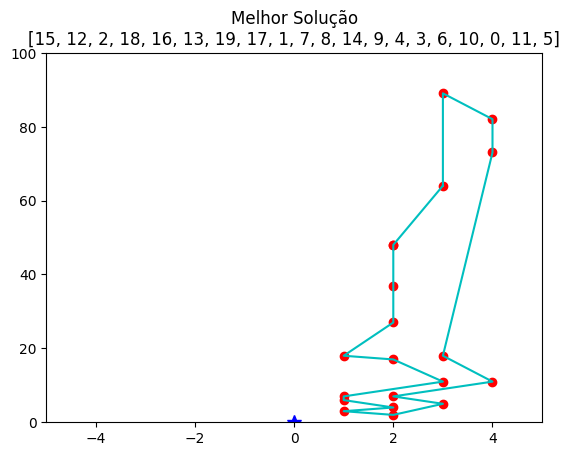

Iteração: 181


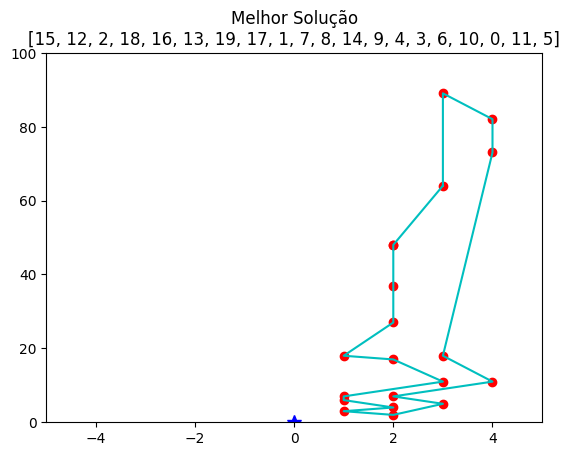

Iteração: 182


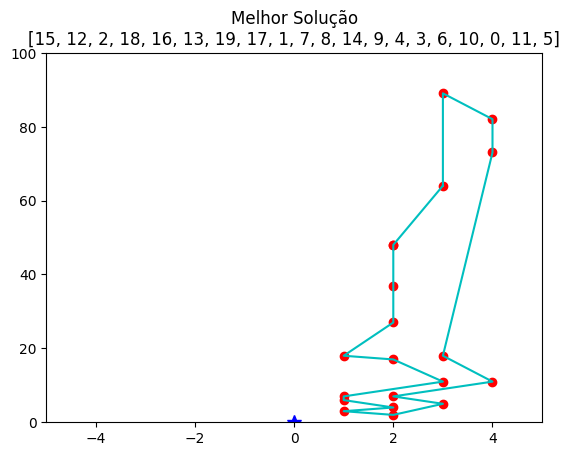

Iteração: 183


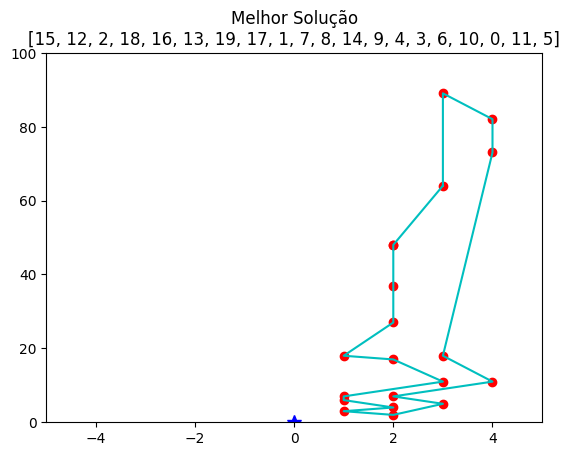

Iteração: 184


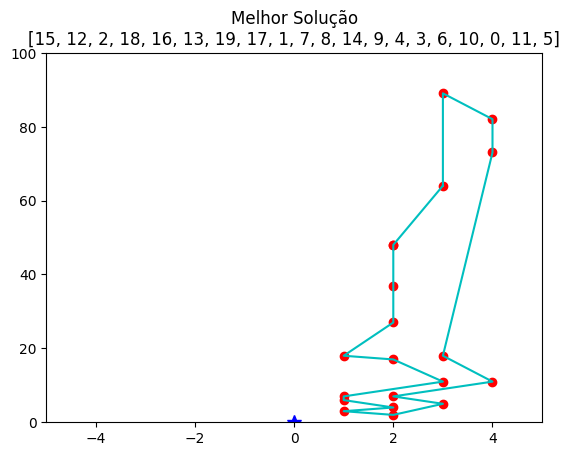

Iteração: 185


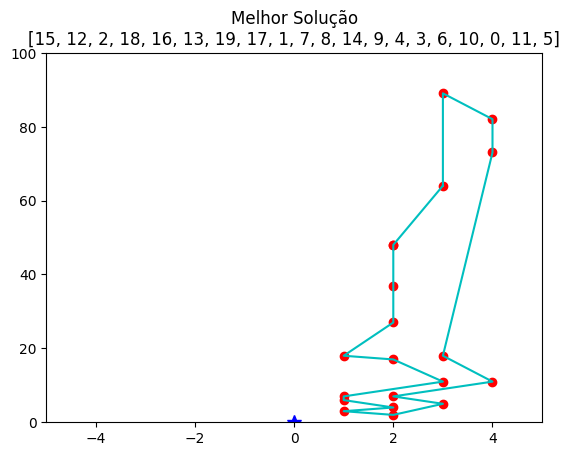

Iteração: 186


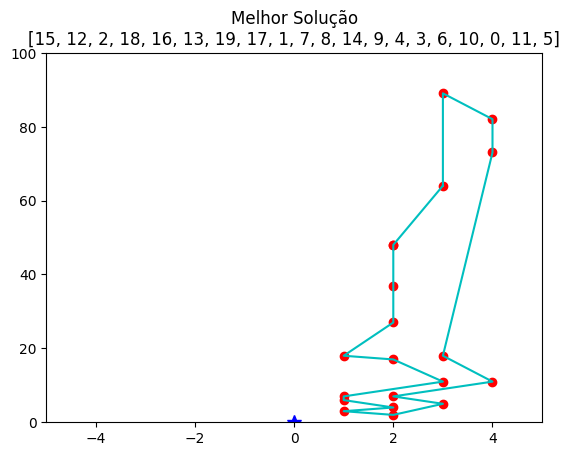

Iteração: 187


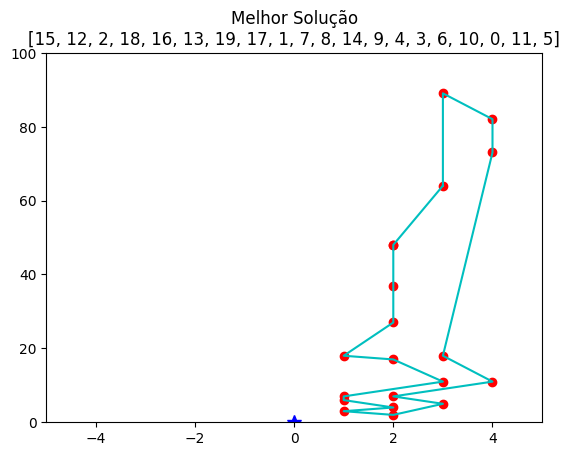

Iteração: 188


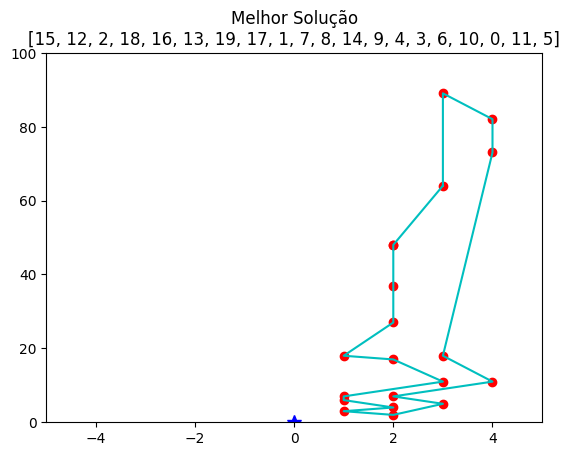

Iteração: 189


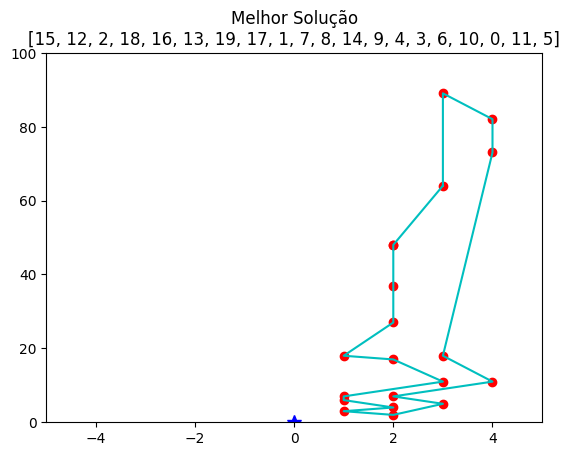

Iteração: 190


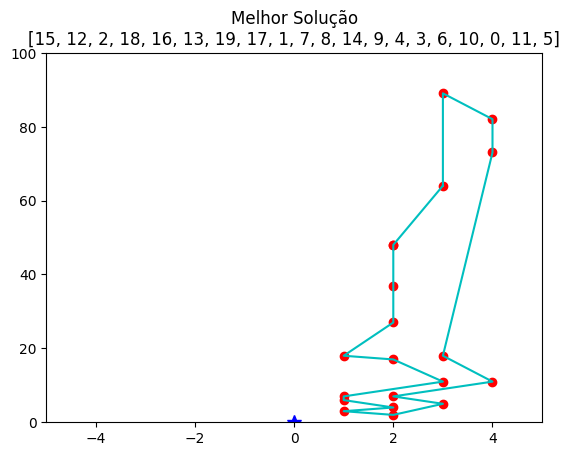

Iteração: 191


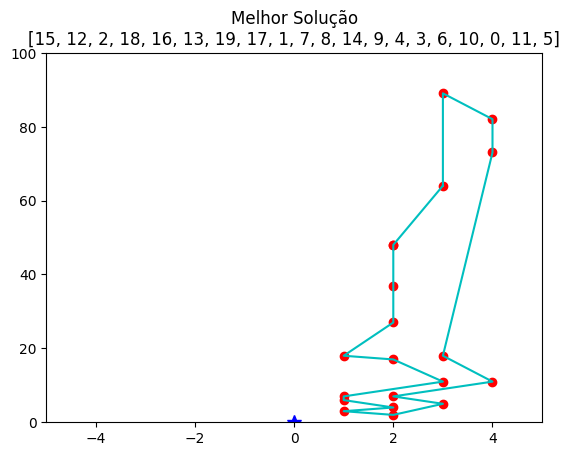

Iteração: 192


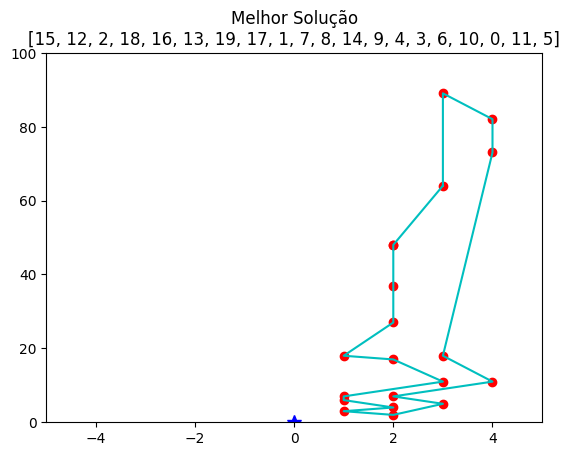

Iteração: 193


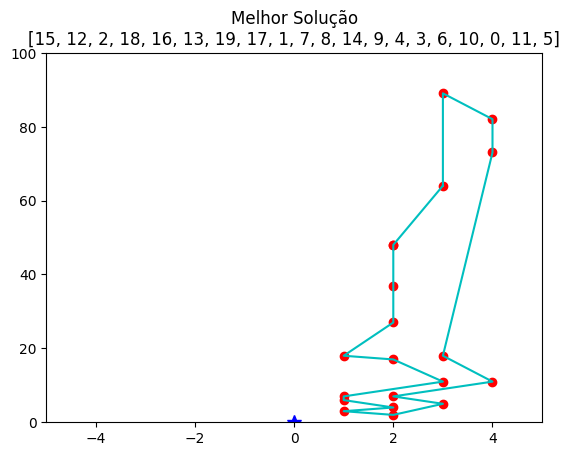

Iteração: 194


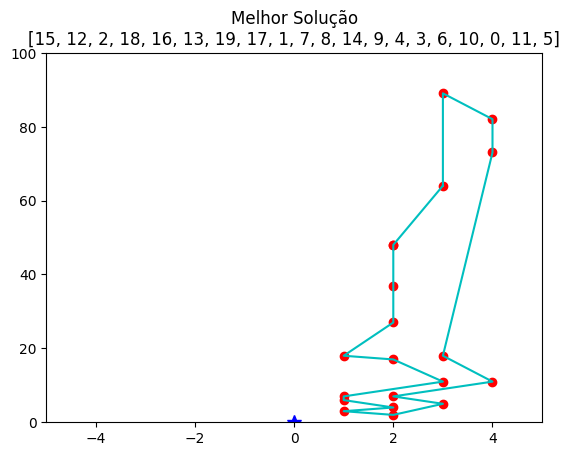

Iteração: 195


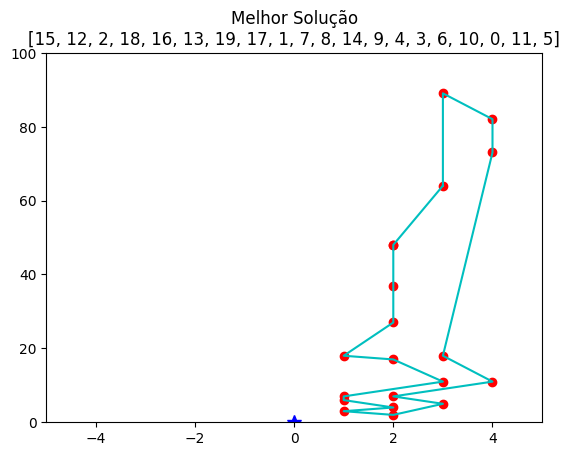

Iteração: 196


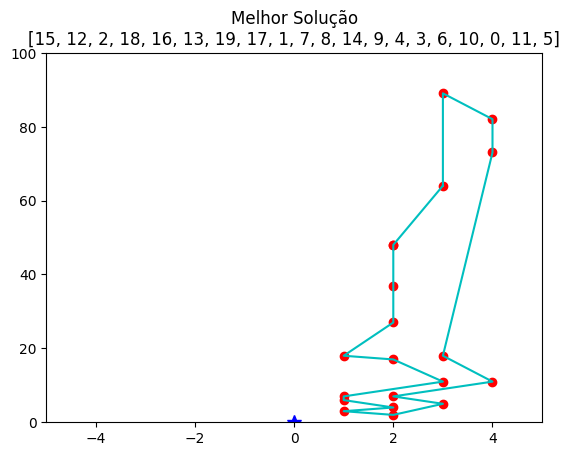

Iteração: 197


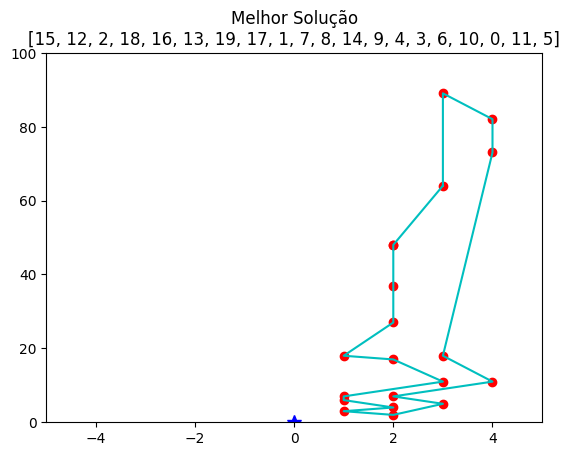

Iteração: 198


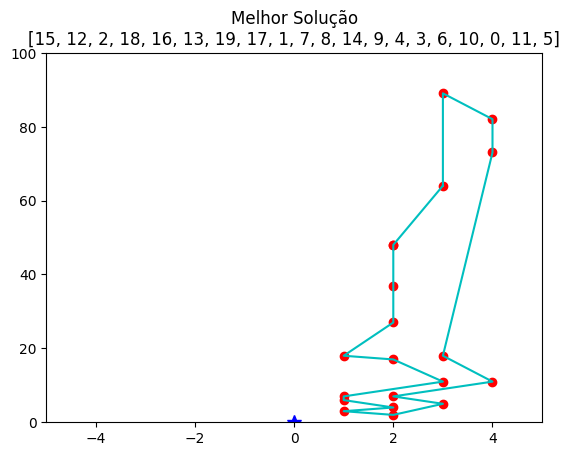

Iteração: 199


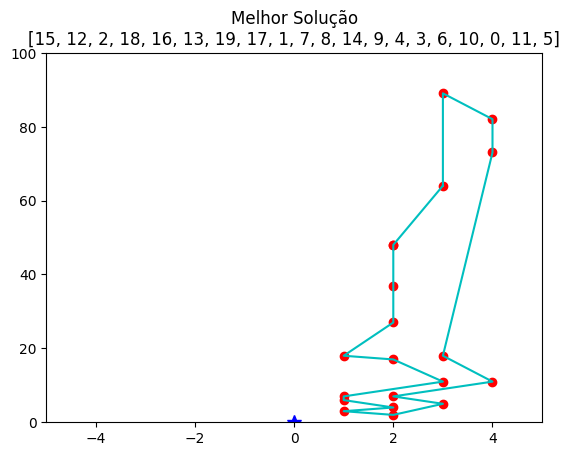

Iteração: 200


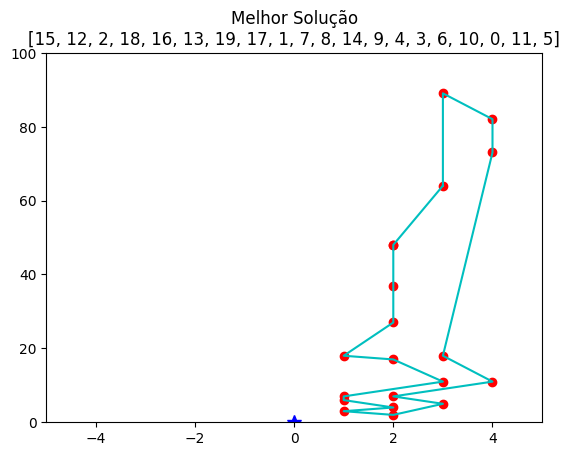

In [ ]:
#otimização GA
best = 0
best_route = []
convergencia = []
for i in range(ITERACOES):
  print("Iteração: {:.0f}".format(i+1))
  pais = selecao_base(fitness)
  filhos = []
  for j in pais:
    filhos.append(crossover(individuos,j))
  individuos = filhos
  for k in range(POPULACAO):
    individuos[k] = mutacao(individuos[k])
  fitness = []
  for k in range(POPULACAO):
    fitness.append(fcusto(FCUSTO,individuos[k]))
    if fitness[-1] > best:
      best = fitness[-1]
      best_route = individuos[k]
  exibe_grafico('Melhor Solução\n' + str(best_route), pontos, best_route)
  fitness_tempo.append(1/best)
  convergencia.append(best)

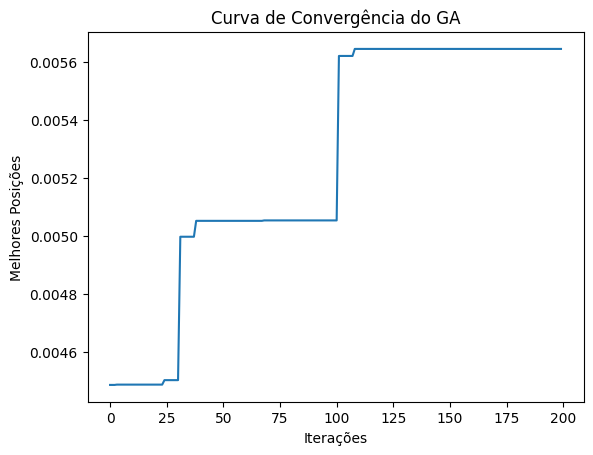

In [ ]:
#exibe curva de convergência dos indivíduos
x = []
y = []
for i in range(ITERACOES):
  x.append(i)
  y.append(convergencia[i])
plt.title("Curva de Convergência do GA")
plt.xlabel("Iterações")
plt.ylabel("Melhores Posições")
plt.plot(x,y)
plt.show()

In [ ]:
for i in range(ITERACOES): print("iteração:",i,"posição:",convergencia[i])

iteração: 0 posição: 0.0021046479371735773
iteração: 1 posição: 0.0021046479371735773
iteração: 2 posição: 0.0021046479371735773
iteração: 3 posição: 0.002352349718678526
iteração: 4 posição: 0.0027242169580472464
iteração: 5 posição: 0.0030391854063874487
iteração: 6 posição: 0.0030391854063874487
iteração: 7 posição: 0.0030391854063874487
iteração: 8 posição: 0.0030391854063874487
iteração: 9 posição: 0.0030391854063874487
iteração: 10 posição: 0.0030405154182144172
iteração: 11 posição: 0.003235359318002895
iteração: 12 posição: 0.004004815286437856
iteração: 13 posição: 0.004647377629738302
iteração: 14 posição: 0.004647377629738302
iteração: 15 posição: 0.004647760131401958
iteração: 16 posição: 0.004647760131401958
iteração: 17 posição: 0.004647760131401958
iteração: 18 posição: 0.004647760131401958
iteração: 19 posição: 0.004647760131401958
iteração: 20 posição: 0.004647760131401958
iteração: 21 posição: 0.0049595234331261725
iteração: 22 posição: 0.004959943870355066
iteração: 